In [1]:
from IPython.display import display, HTML

display(HTML("""<style>.container {width: 300% !important;}</style>"""))

# Contents

# Part 1: Monitoring Alert Prediction

## 1. Exploratory Data Analysis
  Summary statistics and vidualizations

- Univariate analysis

- Missing value analysis and imputation  


## 2. Variable Selection
- Relavant feature engineered covariates with high correlation with the label

- Variable selection with cross validation under XGBoost model
  (LightGBM, LSTM, Time Series Model, Logistic Regression if time permitted)

## 3. Hyper Parameter Tuning 
- Time series cross validation

- Test error estimation from the best model


In [2]:
!pip install missingno > /dev/null 2>&1

In [3]:
!pip install xgboost > /dev/null 2>&1

In [4]:
!pip install  > /dev/null 2>&1

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [6]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [7]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv') 

In [8]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
test['Timestamp'] = pd.to_datetime(test['Timestamp'])

# 1. EDA

## Understand the ditribution and trends of the variables of interest

In [9]:
display(train)

Well_ID           Timestamp Well_Operating_Status Operational_Notes  \
0          101 2023-01-01 00:00:00             Operating               NaN   
1          101 2023-01-01 00:10:00             Operating               NaN   
2          101 2023-01-01 00:20:00             Operating               NaN   
3          101 2023-01-01 00:30:00             Operating               NaN   
4          101 2023-01-01 00:40:00             Operating               NaN   
...        ...                 ...                   ...               ...   
40782      101 2023-10-19 22:10:00             Operating               NaN   
40783      101 2023-10-19 22:20:00             Operating               NaN   
40784      101 2023-10-19 22:30:00             Operating               NaN   
40785      101 2023-10-19 22:40:00             Operating               NaN   
40786      101 2023-10-19 22:50:00             Operating               NaN   

       Acoustic_Sensor_Env_dB  Ambient_Temperature_C  \
0                   49.227346              38.854665   
1                   40.135114              36.311768   
2                   51.190784              38.751977   
3                   45.558002              40.662510   
4                   45.064738              37.945231   
...                       ...                    ...   
40782               47.006170              27.796794   
40783               43.819635              29.067319   
40784               39.870584              26.203226   
40785               42.382936              29.882131   
40786               41.490541              21.044725   

       Casing_Pressure_SensorB_psi  Casing_Pressure_psi  \
0                        50.897459            49.256230   
1                        49.925884            48.734318   
2                        50.518002            49.636435   
3                        51.624718            50.175814   
4                        52.292048            49.078709   
...                            ...                  ...   
40782                    51.779890            52.239625   
40783                    54.324112            51.889230   
40784                    54.024466            53.048127   
40785                    52.041916            52.188194   
40786                    53.847841            52.091557   

       Gearbox_Temperature_C  Gearbox_Vibration_mm_s  Hydraulic_Pressure_psi  \
0                  67.367428                0.517302               30.170903   
1                  71.938489                0.481706               29.941944   
2                  73.476772                0.607282               30.457478   
3                  72.928716                0.634475               31.381904   
4                  68.188568                0.477692               29.956880   
...                      ...                     ...                     ...   
40782              78.502460                0.768184               29.735330   
40783              81.480187                0.556077               28.592517   
40784              79.351414                0.600903               28.322948   
40785              81.092399                0.678572               26.617094   
40786              78.772902                0.603118               29.100776   

       Liquid_Flow_Rate_m3d Lubrication_Status  Maintenance_Code  \
0                100.769050                NaN               NaN   
1                 99.845761                 OK               NaN   
2                103.088886                NaN               NaN   
3                101.089720                NaN               NaN   
4                 98.444687                NaN               NaN   
...                     ...                ...               ...   
40782                   NaN                NaN               NaN   
40783             95.504386                NaN               NaN   
40784             99.713693                NaN               NaN   
40785             98.897580                NaN 

It is shown that Timestamp seems to be cleaned, possibly no duplication or missing. Operational_Notes looks to have many missing values. 

In [10]:
train['Well_ID'].value_counts()

Well_ID
101    40787
Name: count, dtype: int64

In [11]:
test['Well_ID'].value_counts()

Well_ID
101    10197
Name: count, dtype: int64

In [12]:
# Unique Well_ID -> removed
train.drop('Well_ID', axis=1, inplace = True)
test.drop('Well_ID', axis=1, inplace = True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40787 entries, 0 to 40786
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Timestamp                    40787 non-null  datetime64[ns]
 1   Well_Operating_Status        40787 non-null  object        
 2   Operational_Notes            1841 non-null   object        
 3   Acoustic_Sensor_Env_dB       40377 non-null  float64       
 4   Ambient_Temperature_C        40787 non-null  float64       
 5   Casing_Pressure_SensorB_psi  40787 non-null  float64       
 6   Casing_Pressure_psi          40787 non-null  float64       
 7   Gearbox_Temperature_C        39981 non-null  float64       
 8   Gearbox_Vibration_mm_s       40787 non-null  float64       
 9   Hydraulic_Pressure_psi       40787 non-null  float64       
 10  Liquid_Flow_Rate_m3d         39560 non-null  float64       
 11  Lubrication_Status           4009 non-nul

Numerical and categorical variables 

1. Split the data into a. data with only numerical variables, b. data with categorical variables.
2. Summary statistics, visualization of each row for a., b., and the label.

##### Both training data and test data were analyzed to confirm there has been no distribution shift and the inferences from training data set is reliable to the test data set. 

## Summary Statistics: Numerical Covariates

In [14]:
# Split num/categorical data sets separately
num_train = train.select_dtypes(include=['number', 'datetime']).copy()
num_test = test.select_dtypes(include=['number', 'datetime']).copy()


nonnum_train = train.select_dtypes(include=['object', 'category', 'datetime']).copy()
nonnum_test = test.select_dtypes(include=['object', 'category', 'datetime']).copy()

if 'Maintenance_Code' in num_train.columns:
    # Append numeric looking but more of categorical field 
    nonnum_train['Maintenance_Code'] = num_train['Maintenance_Code']
    nonnum_test['Maintenance_Code'] = num_test['Maintenance_Code']
    
    # Drop the field 
    num_train.drop('Maintenance_Code', axis=1, inplace=True)
    num_test.drop('Maintenance_Code', axis=1, inplace=True)

# Change col type to categories 
for colname in nonnum_train.columns:
    if colname == 'Timestamp':
        continue
    train[colname] = train[colname].astype('category')
    test[colname] = test[colname].astype('category')

In [15]:
nonnum_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40787 entries, 0 to 40786
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              40787 non-null  datetime64[ns]
 1   Well_Operating_Status  40787 non-null  object        
 2   Operational_Notes      1841 non-null   object        
 3   Lubrication_Status     4009 non-null   object        
 4   Maintenance_Code       6195 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.6+ MB


In [16]:
num_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40787 entries, 0 to 40786
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Timestamp                    40787 non-null  datetime64[ns]
 1   Acoustic_Sensor_Env_dB       40377 non-null  float64       
 2   Ambient_Temperature_C        40787 non-null  float64       
 3   Casing_Pressure_SensorB_psi  40787 non-null  float64       
 4   Casing_Pressure_psi          40787 non-null  float64       
 5   Gearbox_Temperature_C        39981 non-null  float64       
 6   Gearbox_Vibration_mm_s       40787 non-null  float64       
 7   Hydraulic_Pressure_psi       40787 non-null  float64       
 8   Liquid_Flow_Rate_m3d         39560 non-null  float64       
 9   Motor_Power_kW               40787 non-null  float64       
 10  Polished_Rod_Vibration_mm_s  40787 non-null  float64       
 11  Seismic_Activity_Index       40787 non-nu

To check Timestamp is clean:

In [17]:
train['Timestamp'].value_counts()

Timestamp
2023-01-01 00:00:00    1
2023-07-14 15:50:00    1
2023-07-14 14:30:00    1
2023-07-14 14:40:00    1
2023-07-14 14:50:00    1
                      ..
2023-04-08 08:40:00    1
2023-04-08 08:50:00    1
2023-04-08 09:00:00    1
2023-04-08 09:10:00    1
2023-10-19 22:50:00    1
Name: count, Length: 40787, dtype: int64

In [18]:
if train['Timestamp'].nunique() == len(train):
    print('No duplication of missing on train data')

No duplication of missing on train data


In [19]:
if test['Timestamp'].nunique() == len(test):
    print('No duplication of missing on test data')

No duplication of missing on test data


Sample is generated every 10 minutes.

### Summary Statistics of numerical covariates from train and test data 

In [20]:
train.drop('Timestamp', axis=1).describe()

Acoustic_Sensor_Env_dB  Ambient_Temperature_C  \
count            40377.000000           40787.000000   
mean                45.032760              16.649570   
std                  4.008191              12.161613   
min                 27.446367              -7.482692   
25%                 42.347761               6.072449   
50%                 45.050711              14.810344   
75%                 47.746034              26.042869   
max                 64.470617              48.434472   

       Casing_Pressure_SensorB_psi  Casing_Pressure_psi  \
count                 40787.000000         40787.000000   
mean                     52.017213            50.977222   
std                       2.207906             1.812444   
min                      37.762732            39.291829   
25%                      50.708179            49.896200   
50%                      52.035401            51.010055   
75%                      53.363072            52.114756   
max                     107.039474            58.048367   

       Gearbox_Temperature_C  Gearbox_Vibration_mm_s  Hydraulic_Pressure_psi  \
count           39981.000000            40787.000000            40787.000000   
mean               74.606506                0.536923               28.661963   
std                 4.459383                0.099645                3.194772   
min                33.425641                0.022700               -4.030941   
25%                72.628767                0.482230               28.162855   
50%                74.441966                0.540328               28.992607   
75%                76.880113                0.598432               29.825427   
max               136.535713                1.045505               34.008717   

       Liquid_Flow_Rate_m3d  Motor_Power_kW  Polished_Rod_Vibration_mm_s  \
count          39560.000000    40787.000000                 40787.000000   
mean              96.564020       54.320140                     0.770062   
std               11.888129        6.267621                     0.176020   
min              -19.738754        2.208784                     0.029961   
25%               95.680093       52.902076                     0.665284   
50%               97.935327       54.944160                     0.774181   
75%              100.114266       56.819861                     0.882495   
max              110.529178       75.742814                     1.656087   

       Seismic_Activity_Index  Stroke_Count_Today  Surface_Temperature_C  \
count            40787.000000        40787.000000           40192.000000   
mean                10.152590          285.921593              60.740131   
std                  3.519258          166.256234               2.697658   
min                  5.000000            0.000000              34.951934   
25%                  6.654347          140.000000              59.399225   
50%                 10.329700          284.000000              60.811601   
75%                 13.647788          432.000000              62.264101   
max                 15.000000          572.000000              73.586462   

       Tubing_Pressure_psi  VFD_Speed_pct  Monitoring_Alert  
count         39794.000000   39970.000000      40787.000000  
mean            187.605666      74.017577          0.095006  
std              21.244573       9.932950          0.293226  
min             122.123059      -0.931659          0.000000  
25%             181.217049      71.474073          0.000000  
50%             187.521814      74.941348          0.000000  
75%             193.920106      78.334163          0.000000  
max            1183.873631      94.711603          1.000000

In [21]:
test.drop('Timestamp', axis=1).describe()

Acoustic_Sensor_Env_dB  Ambient_Temperature_C  \
count            10105.000000           10197.000000   
mean                45.003968              33.420882   
std                  4.079176               4.934893   
min                 28.593664              16.239149   
25%                 42.262269              30.001549   
50%                 44.980103              33.894963   
75%                 47.767021              37.052449   
max                 62.057012              46.659348   

       Casing_Pressure_SensorB_psi  Casing_Pressure_psi  \
count                 10197.000000         10197.000000   
mean                     53.295175            52.244423   
std                       2.062929             1.635617   
min                      39.815607            39.682599   
25%                      52.024572            51.229060   
50%                      53.289967            52.242067   
75%                      54.545456            53.301546   
max                      96.943627            57.423304   

       Gearbox_Temperature_C  Gearbox_Vibration_mm_s  Hydraulic_Pressure_psi  \
count            9998.000000            10197.000000            10197.000000   
mean               82.486703                0.593045               27.527529   
std                 4.304631                0.102392                2.800091   
min                35.546725                0.028108                0.000000   
25%                81.119621                0.537249               27.069328   
50%                82.517642                0.594456               27.794726   
75%                83.966331                0.651811               28.527335   
max               136.335501                1.207194               31.988950   

       Liquid_Flow_Rate_m3d  Motor_Power_kW  Polished_Rod_Vibration_mm_s  \
count           9917.000000    10197.000000                 10197.000000   
mean              94.060255       61.409776                     0.862915   
std               10.891772        6.678592                     0.179975   
min              -13.880767        4.203381                     0.051252   
25%               93.087927       59.558520                     0.756595   
50%               95.299679       61.619953                     0.863805   
75%               97.384750       63.879328                     0.970548   
max              107.551253       80.993116                     1.677935   

       Seismic_Activity_Index  Stroke_Count_Today  Surface_Temperature_C  \
count            10197.000000        10197.000000           10039.000000   
mean                 9.397033          286.264980              65.050646   
std                  3.539003          166.381226               2.719774   
min                  5.000000            0.000000              36.285470   
25%                  5.954915          144.000000              63.932287   
50%                  8.750994          288.000000              64.901408   
75%                 12.933120          432.000000              65.899270   
max                 15.000000          572.000000              79.133366   

       Tubing_Pressure_psi  VFD_Speed_pct  
count          9934.000000   10009.000000  
mean            172.264670      74.233544  
std              16.828009       9.470766  
min             126.497509      -0.931659  
25%             170.034837      71.600200  
50%             172.670431      75.109837  
75%             175.120182      78.453064  
max            1135.576849      98.673141

In [22]:
summary_diff = train.drop(['Timestamp', 'Monitoring_Alert'], axis=1).describe() - test.drop('Timestamp', axis=1).describe()
summary_diff = summary_diff.loc[['mean', 'min', '50%', 'max', 'std']]
sorted_diff = summary_diff.loc[:, summary_diff.loc['mean'].abs().sort_values(ascending=False).index]

In [25]:
print('Train data min timestamp:', train['Timestamp'].min(),'Train data min timestamp:', train['Timestamp'].max())
print('Test data min timestamp:', test['Timestamp'].min(),'test data min timestamp:', test['Timestamp'].max())

Train data min timestamp: 2023-01-01 00:00:00 Train data min timestamp: 2023-10-19 22:50:00
Test data min timestamp: 2023-10-19 23:00:00 test data min timestamp: 2023-12-31 23:50:00


### Differences of the statistics between train and test data 
To make sure the assumption of identically distribution

In [26]:
sorted_diff

Ambient_Temperature_C  Tubing_Pressure_psi  Gearbox_Temperature_C  \
mean             -16.771312            15.340996              -7.880197   
min              -23.721841            -4.374450              -2.121085   
50%              -19.084618            14.851383              -8.075675   
max                1.775123            48.296781               0.200213   
std                7.226720             4.416564               0.154753   

      Motor_Power_kW  Surface_Temperature_C  Liquid_Flow_Rate_m3d  \
mean       -7.089637              -4.310515              2.503765   
min        -1.994597              -1.333536             -5.857987   
50%        -6.675793              -4.089807              2.635647   
max        -5.250302              -5.546903              2.977925   
std        -0.410971              -0.022117              0.996357   

      Casing_Pressure_SensorB_psi  Casing_Pressure_psi  \
mean                    -1.277961            -1.267201   
min                     -2.052875            -0.390770   
50%                     -1.254567            -1.232012   
max                     10.095847             0.625063   
std                      0.144977             0.176828   

      Hydraulic_Pressure_psi  Seismic_Activity_Index  Stroke_Count_Today  \
mean                1.134433                0.755557           -0.343387   
min                -4.030941                0.000000            0.000000   
50%                 1.197881                1.578706           -4.000000   
max                 2.019767                0.000000            0.000000   
std                 0.394680               -0.019745           -0.124992   

      VFD_Speed_pct  Polished_Rod_Vibration_mm_s  Gearbox_Vibration_mm_s  \
mean      -0.215967                    -0.092853               -0.056122   
min        0.000000                    -0.021291               -0.005409   
50%       -0.168489                    -0.089624               -0.054128   
max       -3.961538                    -0.021848               -0.161689   
std        0.462184                    -0.003955               -0.002747   

      Acoustic_Sensor_Env_dB  
mean                0.028792  
min                -1.147296  
50%                 0.070607  
max                 2.413605  
std                -0.070984

'Ambient_Temperature_C', 'Tubing_Pressure_psi', 'Gearbox_Temperature_C', 'Motor_Power_kW', 'Surface_Temperature_C' variables has noticeable differences in their distributions between training and test data sets. The changes could be explained from the weather  changes, or there might be some unknown distribution shifts that accounts for the changes of the values of the variables.

## Visualization: Numerical Covariates

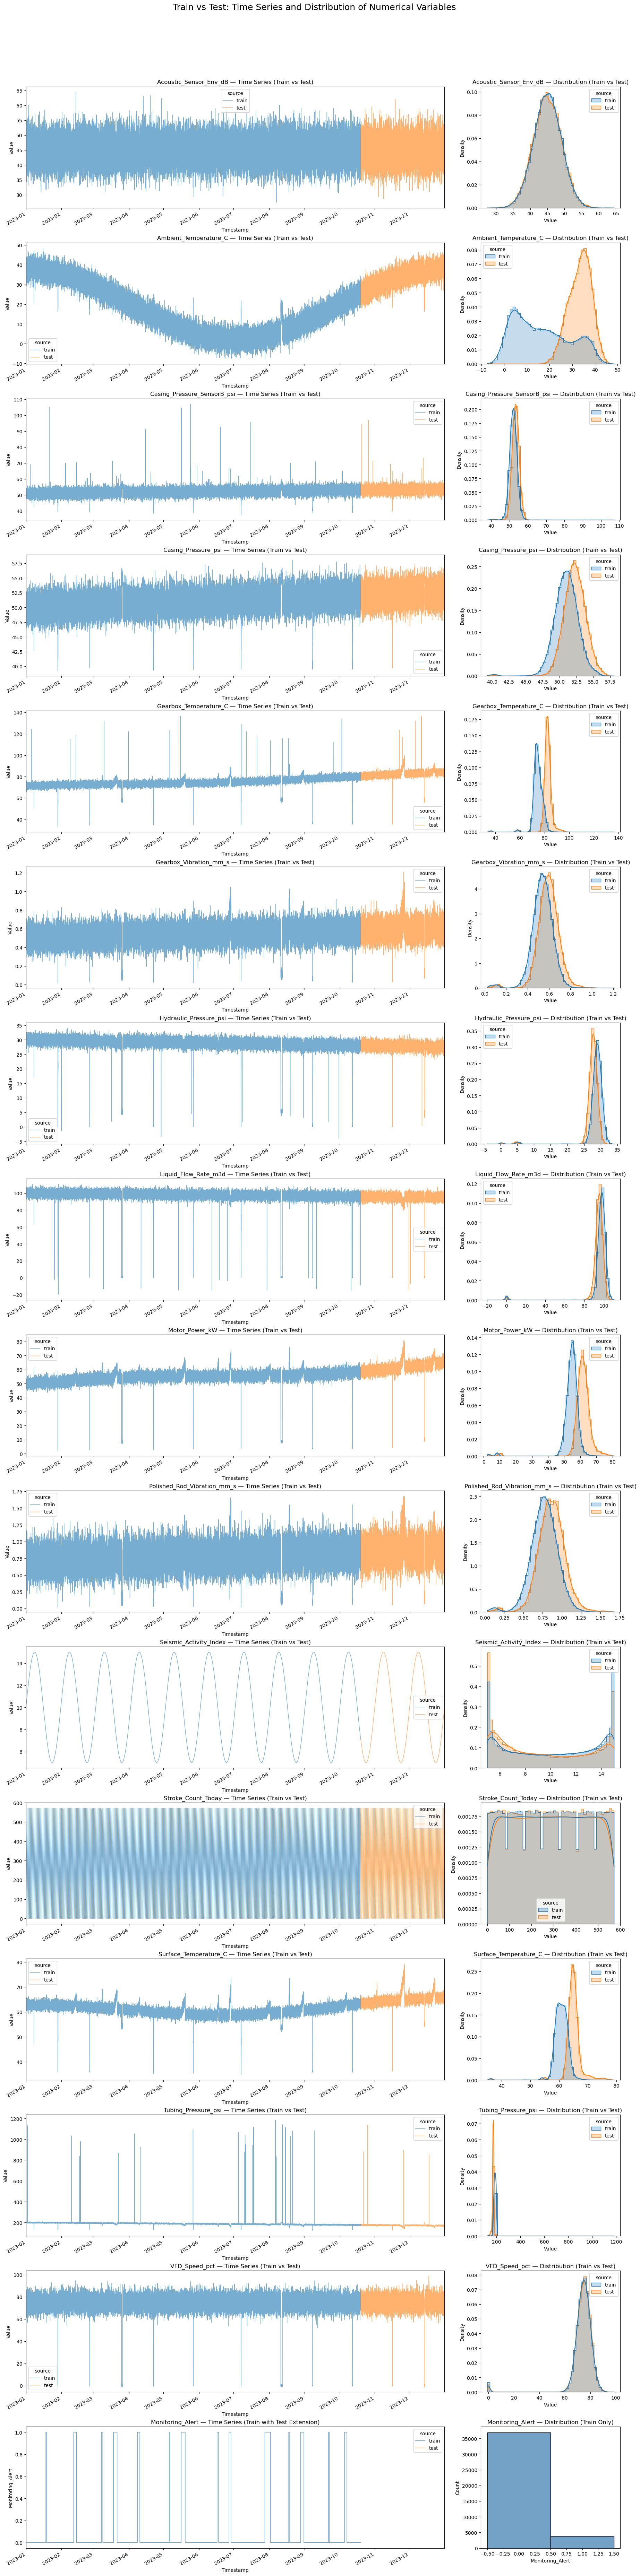

In [27]:
import matplotlib.gridspec as gridspec

# Add source column
train_tagged = num_train.copy()
train_tagged['source'] = 'train'

test_tagged = num_test.copy()
test_tagged['source'] = 'test'

# Combine train and test
combined = pd.concat([train_tagged, test_tagged], axis=0).reset_index(drop=True)

# Use the exact Timestamp range from combined (ensures consistent x-axis)
full_timestamps = combined['Timestamp'].drop_duplicates().sort_values()

min_time = full_timestamps.min()
max_time = full_timestamps.max()

# Extract Monitoring_Alert and reindex to match full timestamps
label_df = num_train[['Timestamp', 'Monitoring_Alert']].drop_duplicates()
label_df = label_df.set_index('Timestamp').sort_index()
label_full = label_df.reindex(full_timestamps)

# Reset index and tag source
label_full = label_full.reset_index().rename(columns={'index': 'Timestamp'})
train_timestamps = set(num_train['Timestamp'])
label_full['source'] = label_full['Timestamp'].isin(train_timestamps).map({True: 'train', False: 'test'})

# Extract numeric feature names (excluding Timestamp and Monitoring_Alert)
num_cols = [col for col in num_test.columns if col not in ['Timestamp', 'Monitoring_Alert']]
n_vars = len(num_cols)

# Create single figure with Monitoring_Alert row included
fig = plt.figure(figsize=(18, 4.5 * (n_vars + 1)), constrained_layout=True)
gs = gridspec.GridSpec(n_vars + 1, 2, width_ratios=[3, 1], figure=fig)

# --- Feature plots ---
for i, col in enumerate(num_cols):
    # Time series (left)
    ax_ts = fig.add_subplot(gs[i, 0])
    
    sns.lineplot(data=combined, x='Timestamp', y=col, hue='source', ax=ax_ts, alpha=0.6, linewidth=1)
    ax_ts.set_title(f'{col} — Time Series (Train vs Test)')
    ax_ts.set_xlabel('Timestamp')
    ax_ts.set_ylabel('Value')
    ax_ts.set_xlim([min_time, max_time])
    for label in ax_ts.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')

    # Distribution (right)
    ax_dist = fig.add_subplot(gs[i, 1])
    sns.histplot(
        data=combined, x=col, hue='source', kde=True, bins=50,
        ax=ax_dist, element='step', stat='density', common_norm=False
    )
    ax_dist.set_title(f'{col} — Distribution (Train vs Test)')
    ax_dist.set_xlabel('Value')
    ax_dist.set_ylabel('Density')

# --- Monitoring_Alert (last row) ---
ax_ts = fig.add_subplot(gs[n_vars, 0])
sns.lineplot(
    data=label_full,
    x='Timestamp',
    y='Monitoring_Alert',
    hue='source',
    ax=ax_ts,
    drawstyle='steps-post',
    alpha=0.7,
    linewidth=1
)
ax_ts.set_title('Monitoring_Alert — Time Series (Train with Test Extension)')
ax_ts.set_xlabel('Timestamp')
ax_ts.set_ylabel('Monitoring_Alert')
ax_ts.set_xlim([min_time, max_time]) 
for label in ax_ts.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')

ax_dist = fig.add_subplot(gs[n_vars, 1])
label_dist = label_full[label_full['source'] == 'train'].dropna(subset=['Monitoring_Alert'])
sns.histplot(
    data=label_dist,
    x='Monitoring_Alert',
    bins=2,
    discrete=True,
    color='steelblue',
    ax=ax_dist
)
ax_dist.set_title("Monitoring_Alert — Distribution (Train Only)")
ax_dist.set_xlabel("Monitoring_Alert")
ax_dist.set_ylabel("Count")

# Final layout with suptitle
fig.suptitle("Train vs Test: Time Series and Distribution of Numerical Variables", fontsize=18, y=1.03)
plt.show()

The variables trends over time and their distribution density is plotted. The colour difference in a plot indicates the source of the data.


Findings:

1. Training and test data set are consistent and there seem to be no extreme changes over time of variables.
2. The label is unbalanced.
3. There seem to be occasional and repeating extreme values over time on sesored data. Research on the extreme time series values is required.

## Summary Statistics: Categorical Data

In [28]:
# Categorical variables' marginal distribution comparison 
cat_cmpr_list = []
for colname in [col for col in nonnum_train.columns if col != 'Timestamp']:
    nn_tr_mr = nonnum_train[colname].value_counts(normalize=True).reset_index()
    nn_ts_mr =nonnum_test[colname].value_counts(normalize=True).reset_index()
    nn_tr_mr.rename(columns={'proportion':'Proportion (Training)'},inplace = True)
    nn_ts_mr.rename(columns={'proportion':'proportion (Test)'},inplace = True)
    cat_smmry_cmpr = nn_tr_mr.merge(nn_ts_mr, how = 'outer')
    cat_cmpr_list.append(cat_smmry_cmpr)

## Distributions of variables (training/test)

In [29]:
for i in range(len(cat_cmpr_list)):
    display(cat_cmpr_list[i])

Well_Operating_Status  Proportion (Training)  proportion (Test)
0           Maintenance               0.004609           0.001961
1             Operating               0.985412           0.987741
2               Standby               0.008434           0.009513
3               Startup               0.001545           0.000785

Operational_Notes  Proportion (Training)  proportion (Test)
0   Bringing online after workover               0.004889           0.002217
1       Checking surface equipment               0.002716                NaN
2         Confirming stroke length               0.003802                NaN
3                  Flow consistent               0.030418           0.035477
4                   Flow rate drop               0.048343           0.062084
5            Flowline pressured up               0.003802                NaN
6                Fluid level check               0.010320           0.004435
7             Fluid pound detected               0.047800           0.055432
8       Gas interference suspected               0.056491           0.050998
9               Gearbox oil change               0.008148           0.006652
10                 High motor amps               0.053232           0.057650
11          High vibration gearbox               0.050516           0.046563
12                 Initial strokes               0.004889           0.006652
13            Monitoring pressures               0.023900           0.039911
14               Nominal operation               0.027159           0.026608
15                Paraffin cleaned               0.006518           0.002217
16               Parameters logged               0.029875           0.037694
17     Polished rod clamp adjusted               0.017925           0.002217
18       Polished rod load erratic               0.066268           0.050998
19            Possible rod parting               0.055405           0.066519
20           Pressure spike tubing               0.061923           0.057650
21                Pressures stable               0.030961           0.024390
22                   Pump serviced               0.005432           0.006652
23               Rod string pulled               0.007061                NaN
24                   Routine check               0.009234           0.004435
25       Routine check by operator               0.025530           0.031042
26              Stroke rate steady               0.031505           0.044346
27               Stuffing box leak               0.059750           0.057650
28           Stuffing box replaced               0.010320           0.002217
29            Temp anomaly gearbox               0.047257           0.068736
30                     VFD ramp up               0.001630           0.002217
31                    Valve repair               0.008691           0.006652
32             Waiting on flowline               0.026616           0.028825
33        Weather condition normal               0.028789           0.026608
34          Well restart initiated               0.002716                NaN
35        Well shut-in - low price               0.026616           0.022173
36   Well shut-in - surface repair               0.027159           0.024390
37   Well shut-in - waiting orders               0.027159           0.035477
38            Workover rig on site               0.009234           0.002217

Lubrication_Status  Proportion (Training)  proportion (Test)
0                Low                0.10676           0.102021
1                 OK                0.89324           0.897979

Maintenance_Code  Proportion (Training)  proportion (Test)
0             501.0               0.503148           0.517906
1             502.0               0.196287           0.203168
2             610.0               0.151251           0.139118
3             705.0               0.095722           0.091598
4             999.0               0.053592           0.048209

Their distribution over their time period seems consistent.

## Visualization: Categorical Data 


The plot below illustrates the distributions and their changes over time of the variables of interest.

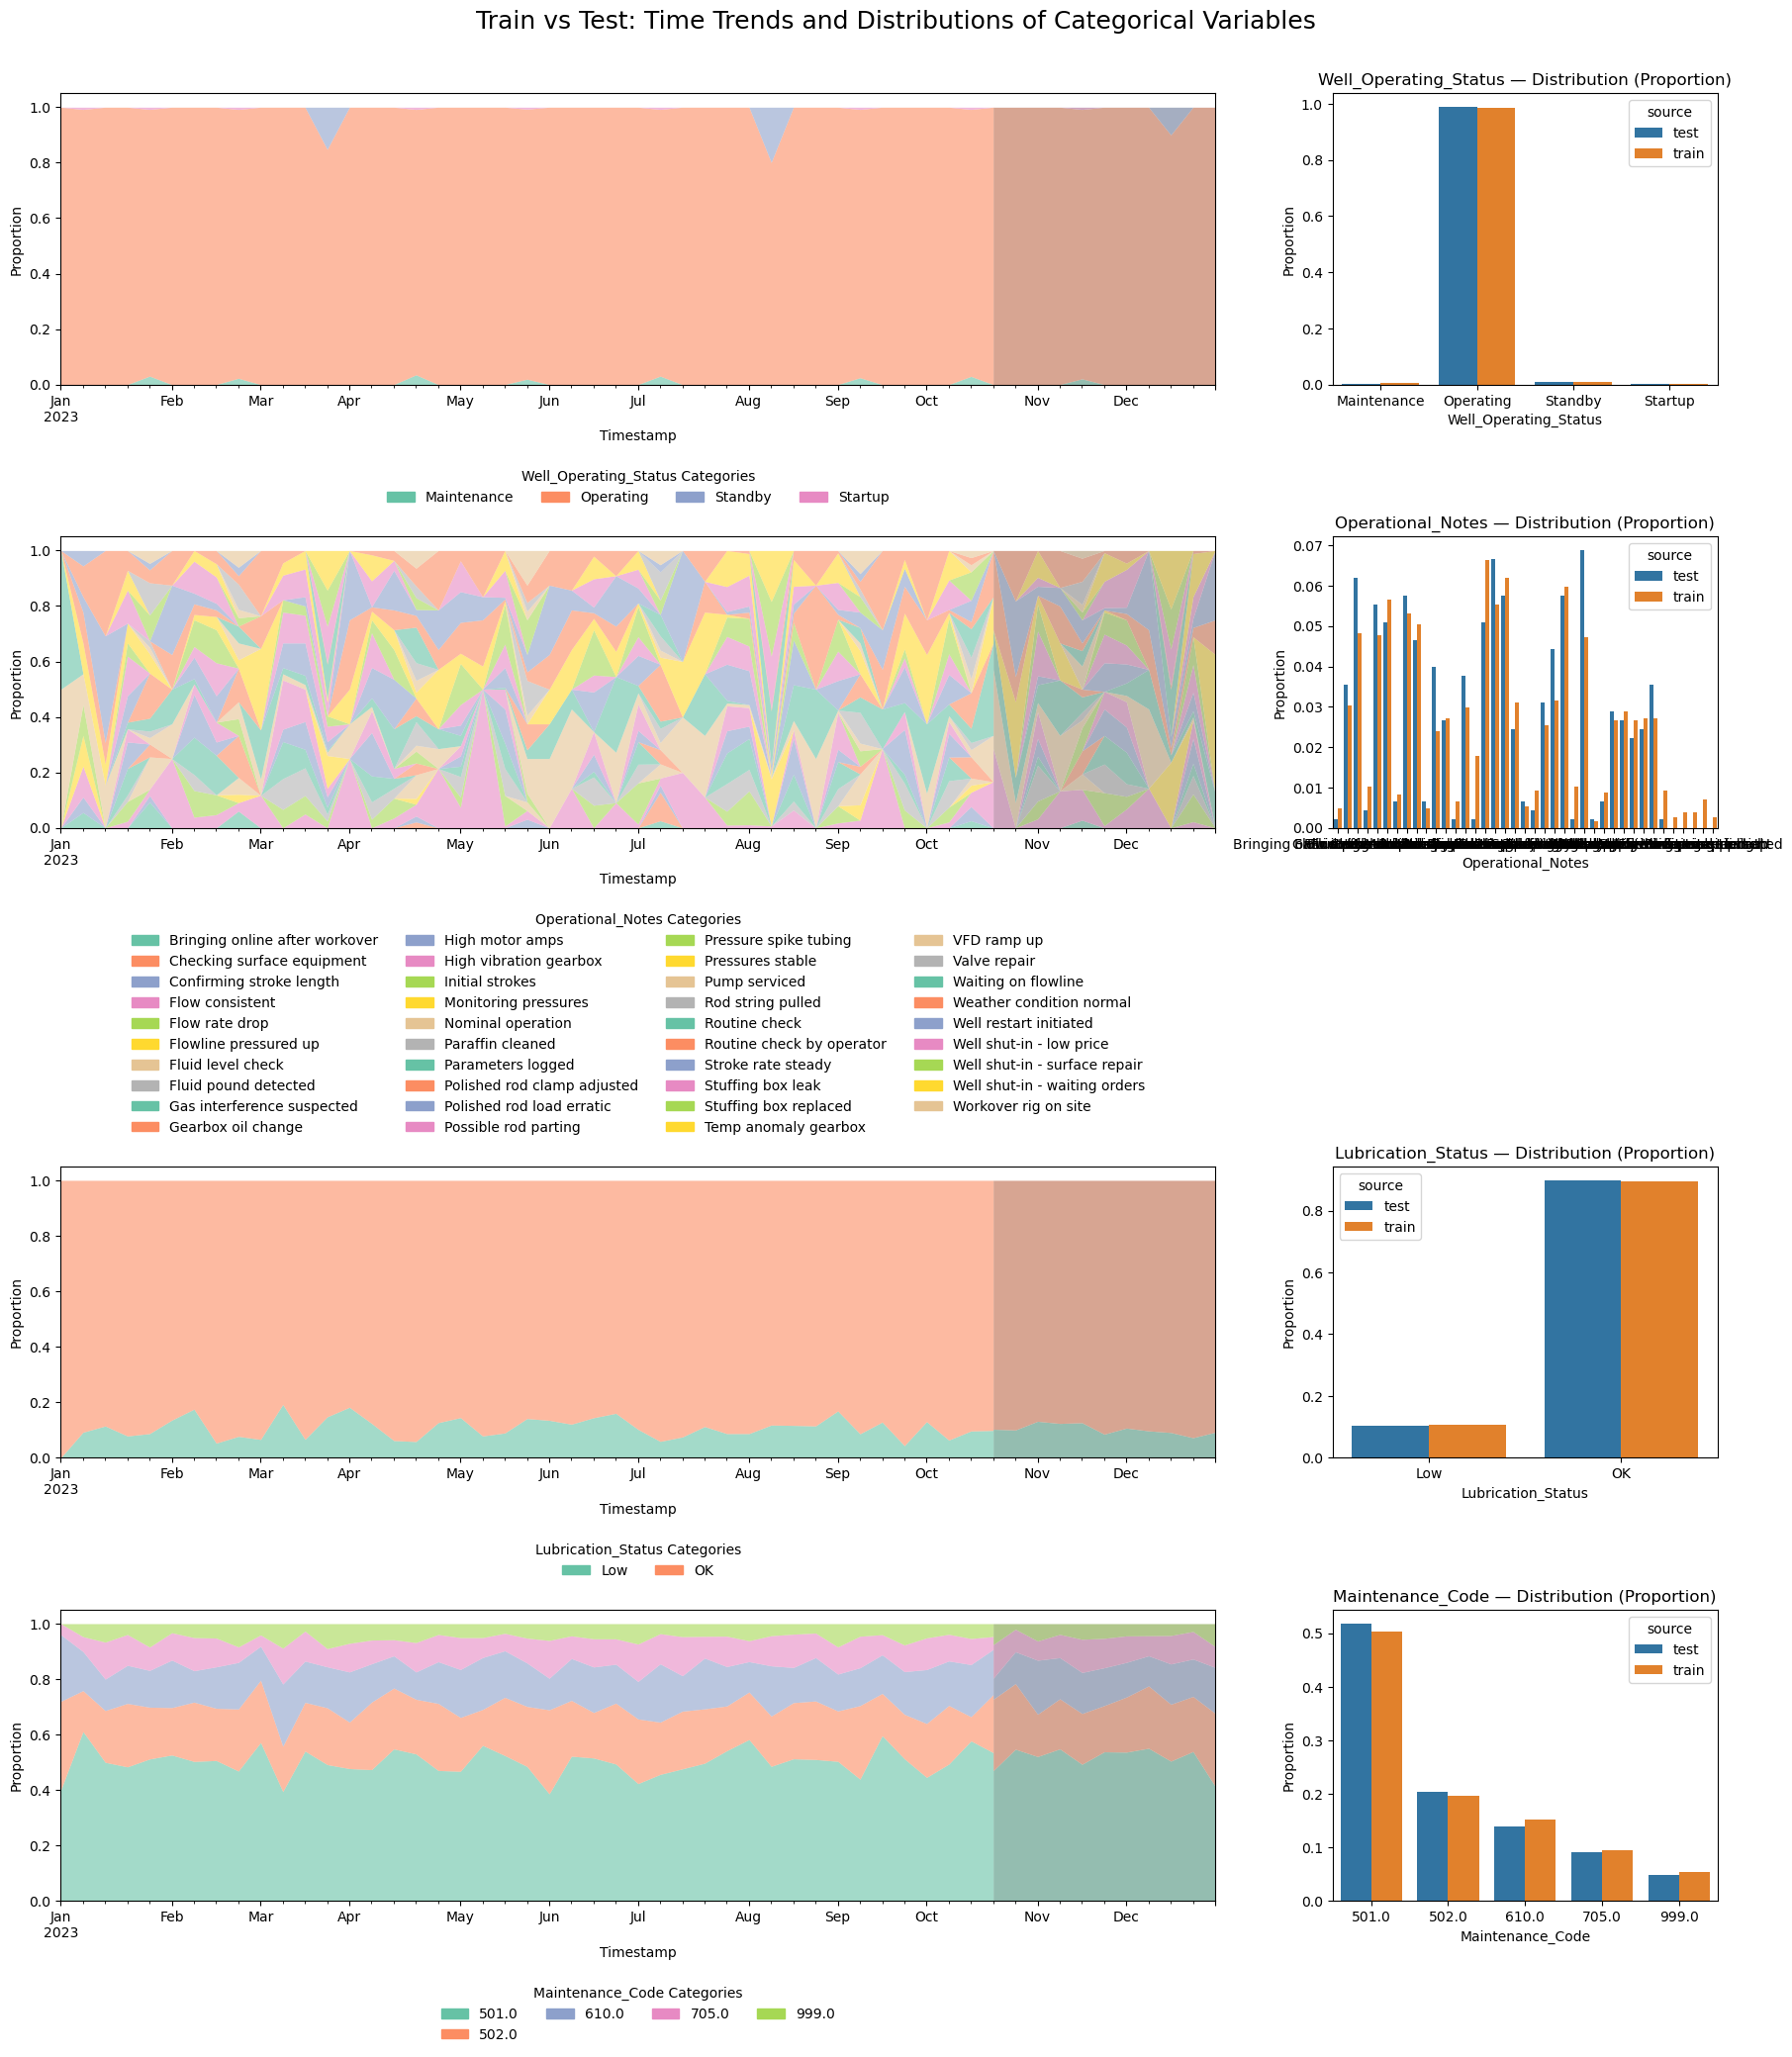

In [30]:
# Add source tag
nonnum_train['source'] = 'train'
nonnum_test['source'] = 'test'
combined_cat = pd.concat([nonnum_train, nonnum_test], axis=0).reset_index(drop=True)

# Timestamp range
full_timestamps = combined_cat['Timestamp'].drop_duplicates().sort_values()
min_time = full_timestamps.min()
max_time = full_timestamps.max()

# Categorical columns (excluding Timestamp/source)
cat_cols = [col for col in nonnum_train.columns if col not in ['Timestamp', 'source']]
n_cats = len(cat_cols)

# Create 2 subplots per categorical variable (train/test on left, distribution on right)
fig = plt.figure(figsize=(18, 5 * n_cats), constrained_layout=True)
gs = gridspec.GridSpec(n_cats, 2, width_ratios=[3, 1], figure=fig)


# Assign base colors per category value
category_color_maps = {}

for col in cat_cols:
    all_categories = sorted(combined_cat[col].dropna().unique())
    base_colors = sns.color_palette("Set2", len(all_categories))
    base_map = dict(zip(all_categories, base_colors))
    category_color_maps[col] = base_map

for i, col in enumerate(cat_cols):
    # Prepare proportion data
    freq = combined_cat.groupby([pd.Grouper(key='Timestamp', freq='W'), col, 'source']).size().reset_index(name='count')
    freq['total'] = freq.groupby(['Timestamp', 'source'])['count'].transform('sum')
    freq['proportion'] = freq['count'] / freq['total']

    # LEFT: Faceted stacked area plots (train and test) in one subplot area
    ax_area = fig.add_subplot(gs[i, 0])

    for source_value, color in zip(['train', 'test'], ['tab:blue', 'tab:orange']):
        subset = freq[freq['source'] == source_value]    
        pivoted = subset.pivot_table(index='Timestamp', columns=col, values='proportion', aggfunc='sum').fillna(0)
        
        # Use same base color per category, with adjusted brightness
        def adjust_color(base_color, brightness=1.0):
            r, g, b = base_color
            return (r * brightness, g * brightness, b * brightness)
        
        # Train = base color, Test = slightly darker
        brightness = 1.0 if source_value == 'train' else 0.75
        colors = [adjust_color(category_color_maps[col][cat], brightness) for cat in pivoted.columns]
        
        pivoted.plot.area(
            ax=ax_area,
            stacked=True,
            alpha=0.6,
            linewidth=0,
            color=colors,
            legend=False  
        )

    ax_area.set_xlim([min_time, max_time])
    ax_area.set_xlabel("Timestamp")
    ax_area.set_ylabel("Proportion")

    # Only add one legend for the categories (based on base_map)
    handles = []
    labels = []
    
    for category, color in category_color_maps[col].items():
        patch = plt.matplotlib.patches.Patch(color=color, label=category)
        handles.append(patch)
        labels.append(category)
    
    # Horizontal legend below the plot
    ax_area.legend(
        handles=handles,
        title=f"{col} Categories",
        loc='upper center',
        bbox_to_anchor=(0.5, -0.25),
        ncol=min(4, len(handles)),  # Adjust column count based on number of categories
        frameon=False)


    # RIGHT: Proportional barplot (train vs test)
    ax_bar = fig.add_subplot(gs[i, 1])
    dist = combined_cat.groupby(['source', col]).size().reset_index(name='count')
    dist['total'] = dist.groupby('source')['count'].transform('sum')
    dist['proportion'] = dist['count'] / dist['total']
    sns.barplot(data=dist, x=col, y='proportion', hue='source', ax=ax_bar)
    ax_bar.set_title(f"{col} — Distribution (Proportion)")
    ax_bar.set_xlabel(col)
    ax_bar.set_ylabel("Proportion")

fig.suptitle("Train vs Test: Time Trends and Distributions of Categorical Variables", fontsize=18, y=1.03)
plt.show()

Findings:

1. Training and test data seem to be from the same distribution and there seems no distribution shift.
2. Categorical values for Well_Operating_Status, Lubrication_Status, and Maintenance_Code are unbalanced, implying the major category indicates normal condition.

The plot below shows the changes of quantity over time for each variable.

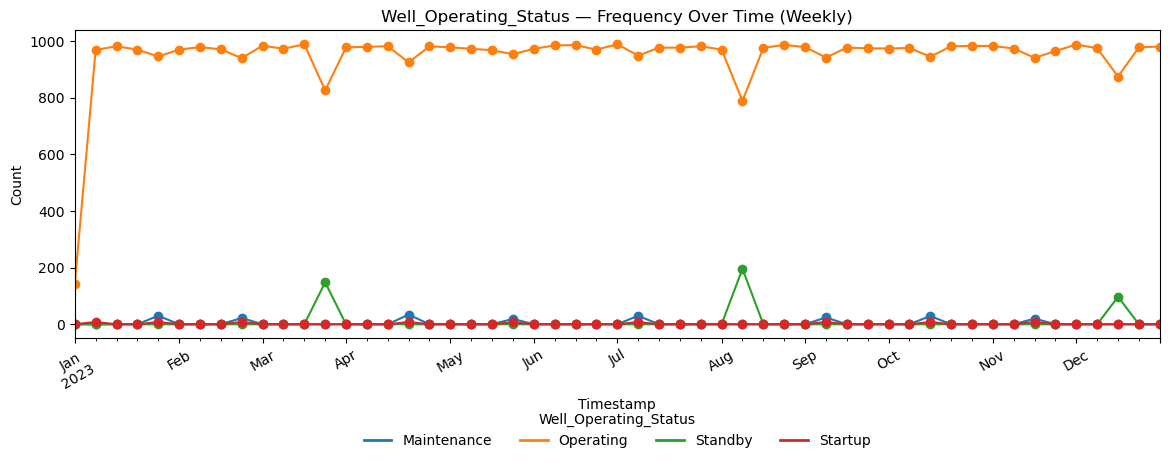

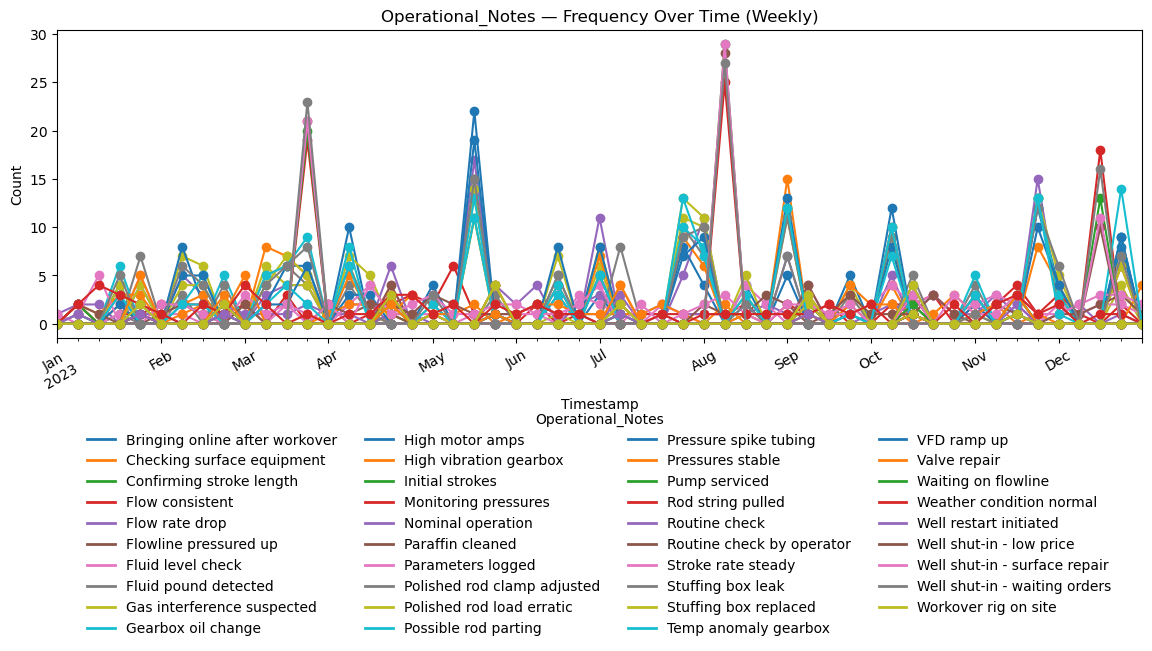

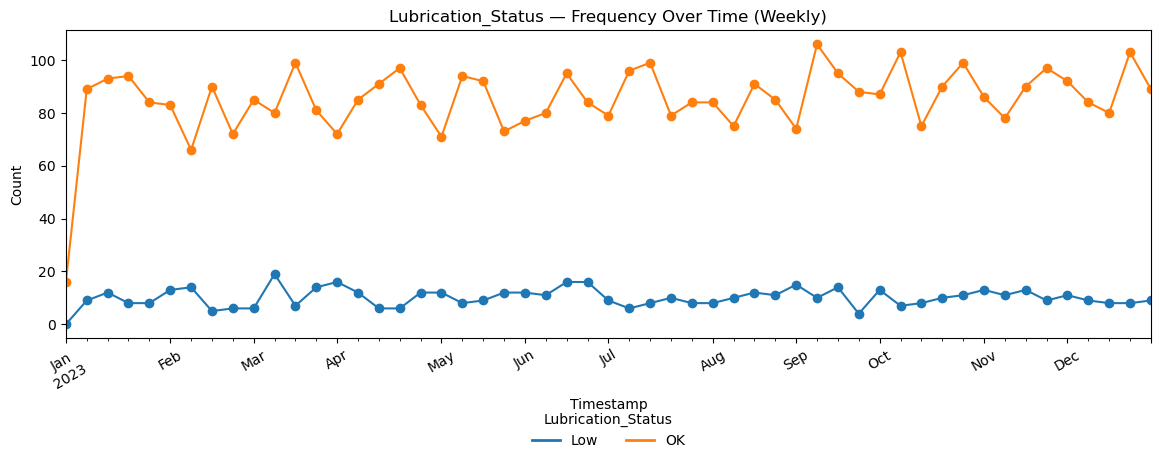

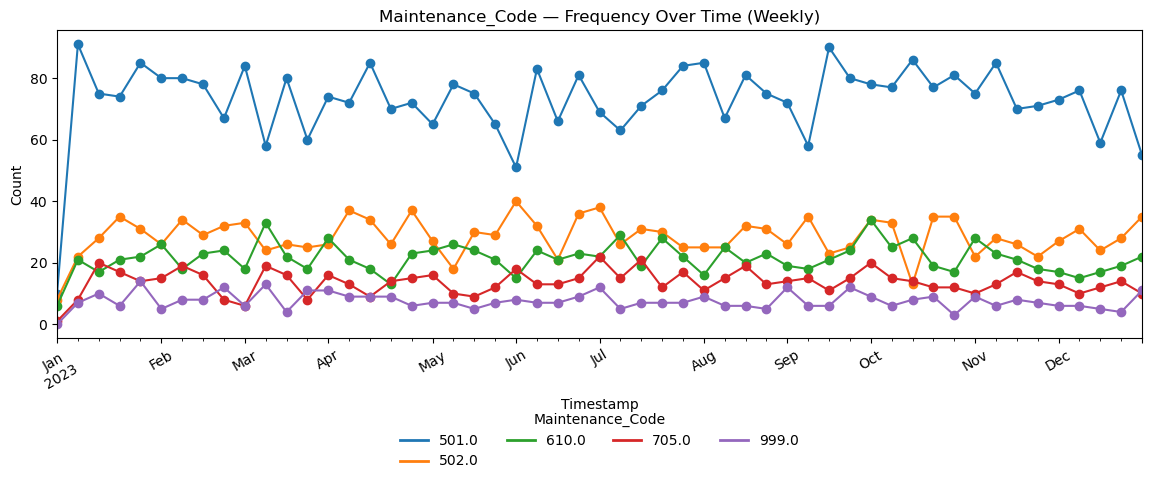

In [31]:
for col in cat_cols:
    plt.figure(figsize=(14, 4))
    
    # Group by week and category
    freq = combined_cat.groupby([pd.Grouper(key='Timestamp', freq='W'), col]).size().reset_index(name='count')

    # Pivot for plotting
    freq_pivot = freq.pivot(index='Timestamp', columns=col, values='count').fillna(0)

    # Plot without legend
    ax = plt.gca()
    freq_pivot.plot(ax=ax, marker='o', legend=False)

    # Title and axis formatting
    ax.set_title(f"{col} — Frequency Over Time (Weekly)")
    # ax.set_xlabel("Timestamp")
    ax.set_ylabel("Count")
    ax.set_xlim([min_time, max_time])
    ax.tick_params(axis='x', rotation=30)

    # Custom horizontal legend below the plot
    handles = [plt.Line2D([0], [0], color=ax.lines[i].get_color(), lw=2) for i in range(len(freq_pivot.columns))]
    labels = freq_pivot.columns.tolist()

    ax.legend(
        handles=handles,
        labels=labels,
        title=col,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=min(4, len(labels)),
        frameon=False
    )

    # plt.tight_layout(rect=[0.1, 0.1, 1, 1])
    plt.show()

It is found that there are some noticeiable peaks - in late Mar, mid May, early Aug (highest), ... - over time for Operational_Notes. Other variables looks stable in their frequencies.

Overall, there seem to be no differences of distributions of concern from categorical variables.  
Relationship between 1. Alerting signals (label), 2. Extreme values of numericals, 3. Frequency changes of categoricals could be analyzed.

# Univariate Analysis on the Label

In [32]:
# Distribution of Y 
print("Counts: \n", train['Monitoring_Alert'].value_counts())

Counts: 
 Monitoring_Alert
0    36912
1     3875
Name: count, dtype: int64


In [33]:
alert_counts = train['Monitoring_Alert'].value_counts(normalize=True).rename("Proportion")
alert_counts = alert_counts.reset_index().rename(columns={'index': 'Label'})

In [34]:
alert_counts

Monitoring_Alert  Proportion
0                 0    0.904994
1                 1    0.095006

Note - unbalanced. 90% accuracy is the baseline.

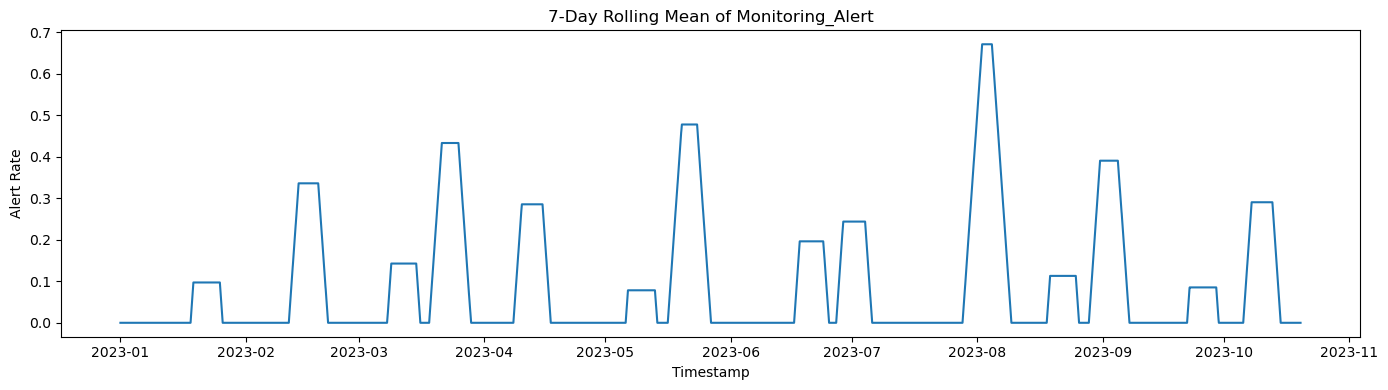

In [35]:
# Prep time-based fields
def add_time_features(df):
    df = df.copy()  # to avoid modifying in-place

    df['Hour'] = df['Timestamp'].dt.hour
    df['Weekday'] = df['Timestamp'].dt.dayofweek
    df['Date'] = df['Timestamp'].dt.floor('D')
    df['IsWeekend'] = (df['Weekday'] >= 5).astype(int)
    df['WeekOfMonth'] = (df['Timestamp'].dt.day - 1) // 7

    return df

train = add_time_features(train)
test = add_time_features(test)

# 3. Rolling 7-day average
train_roll = train.copy()
train_roll['Rolling_7d'] = train_roll['Monitoring_Alert'].rolling(window=144*7, min_periods=1).mean()
plt.figure(figsize=(14, 4))
plt.plot(train_roll['Timestamp'], train_roll['Rolling_7d'])
plt.title("7-Day Rolling Mean of Monitoring_Alert")
plt.ylabel("Alert Rate")
plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()

Findings:  
1. There are some isolated spikes of 12 - 14 times and the highests in some months - Aug, mid May, late March. The spikes look alike to the Operational_Notes. The correlation should be investigated throughly as the causation might be the opposite of desired.
2. Seasonality doesn't seem to exist.

## Autocorrelation Study

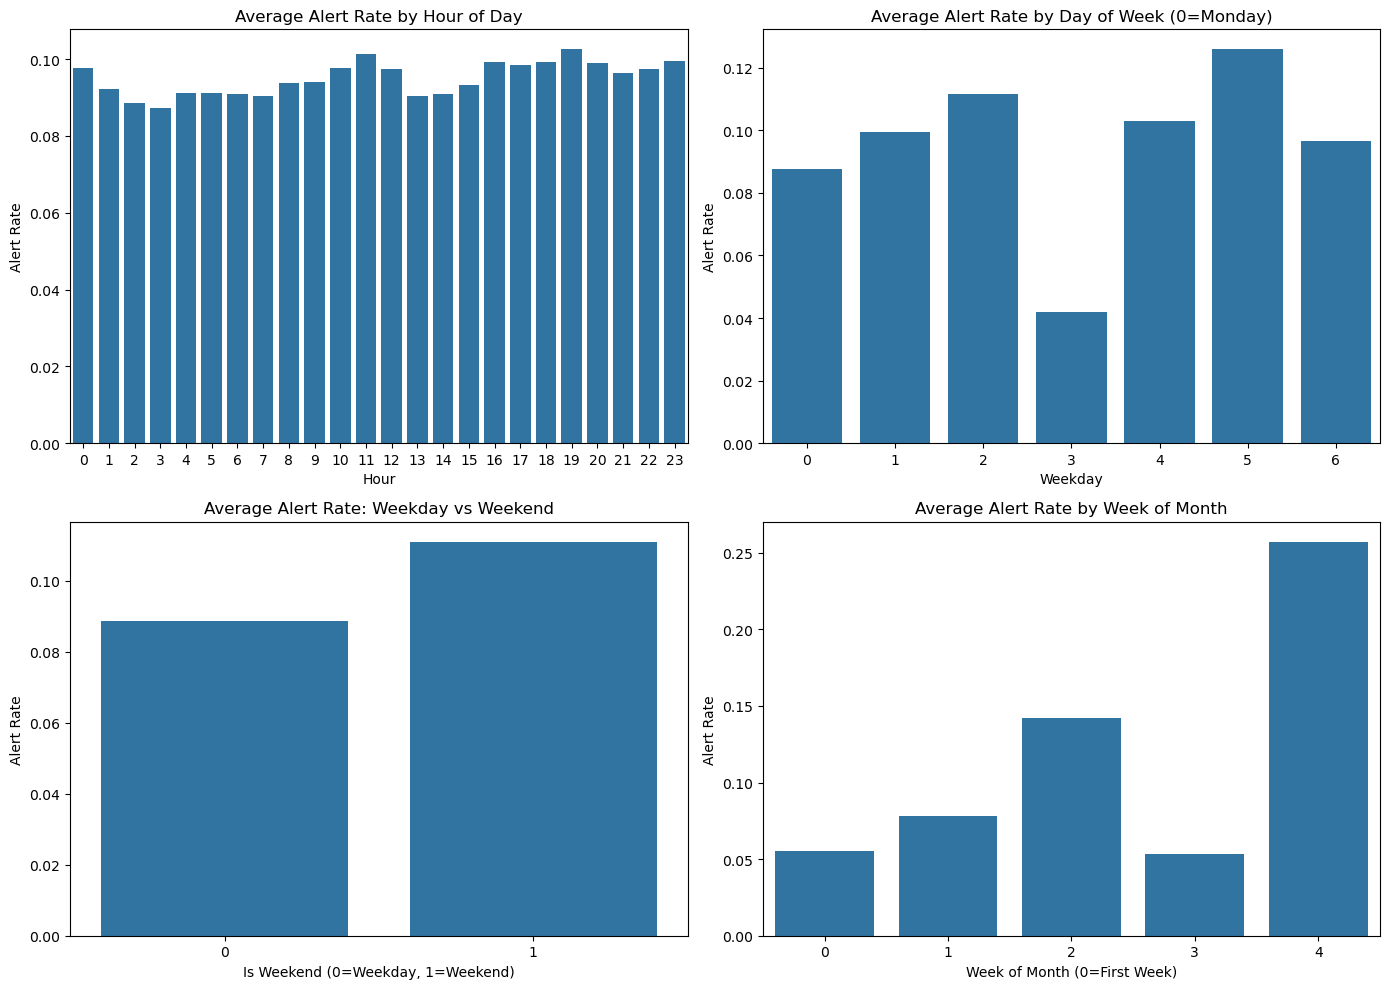

In [36]:
# Compute group statistics
hourly = train.groupby('Hour')['Monitoring_Alert'].mean()
weekday = train.groupby('Weekday')['Monitoring_Alert'].mean()
isweekend = train.groupby('IsWeekend')['Monitoring_Alert'].mean()
weekofmonth = train.groupby('WeekOfMonth')['Monitoring_Alert'].mean()

# Set up side-by-side plots in 3 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # flatten to 1D array for easier indexing

# Plot 1: Alert rate by hour of day
sns.barplot(x=hourly.index, y=hourly.values, ax=axes[0])
axes[0].set_title("Average Alert Rate by Hour of Day")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Alert Rate")

# Plot 2: Alert rate by weekday
sns.barplot(x=weekday.index, y=weekday.values, ax=axes[1])
axes[1].set_title("Average Alert Rate by Day of Week (0=Monday)")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Alert Rate")

# Plot 3: Alert rate by IsWeekend
sns.barplot(x=isweekend.index, y=isweekend.values, ax=axes[2])
axes[2].set_title("Average Alert Rate: Weekday vs Weekend")
axes[2].set_xlabel("Is Weekend (0=Weekday, 1=Weekend)")
axes[2].set_ylabel("Alert Rate")

# Plot 4: Alert rate by Week of Month
sns.barplot(x=weekofmonth.index, y=weekofmonth.values, ax=axes[3])
axes[3].set_title("Average Alert Rate by Week of Month")
axes[3].set_xlabel("Week of Month (0=First Week)")
axes[3].set_ylabel("Alert Rate")


# Final layout adjustment
plt.tight_layout()
plt.show()

All of the time features seem correlated with the label. 

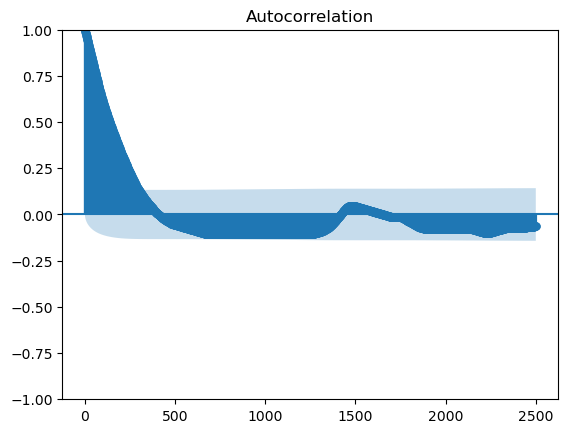

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train['Monitoring_Alert'], lags=2500)
plt.show()

Strong autocorrelation from short term lags. Lag 1 to lag 50 could be considered although not meaningful in the sense of domain knowledge.

# Missing value Analysis
The missingness itself can be an indicator or information of obtainable.

Type of missing values  
- MCAR (Missing Completely At Random): The missingness is entirely random and unrelated to any observed or unobserved data.
- MAR (Missing At Random): The missingness depends only on observed data, not on the missing values themselves.
- MNAR (Missing Not At Random): The missingness depends on the unobserved data — the values that are missing influence the likelihood of being missing.

Searching on the types of missing is helpful for imputing them.

Next steps:
1. Column-wise % missing: Helps you decide imputation vs. removal.
2. Row-wise % missing: Helps detect bad rows (e.g., mostly missing).
3. Compare train vs. test: Checks for data leakage or distribution shift.


### Column-wise missing comparison

In [38]:
# === 6. Missing Value Analysis ===
def missing_percent(x):
    return x.isna().sum() / len(x) * 100

mss_cl_tr = train.apply(missing_percent)
mss_cl_tst = test.apply(missing_percent)
mss_cl_tr_wo_y = mss_cl_tr.drop(labels='Monitoring_Alert', errors='ignore')

missing_summary = pd.concat([mss_cl_tr, mss_cl_tst], axis=1)
missing_summary.rename(columns={0:'Training', 1:'Test'},inplace = True)

In [39]:
missing_summary.sort_values(by = 'Training', ascending= False)

Training       Test
Operational_Notes            95.486307  95.577131
Lubrication_Status           90.170888  89.810729
Maintenance_Code             84.811337  85.760518
Liquid_Flow_Rate_m3d          3.008311   2.745906
Tubing_Pressure_psi           2.434599   2.579190
VFD_Speed_pct                 2.003089   1.843680
Gearbox_Temperature_C         1.976120   1.951554
Surface_Temperature_C         1.458798   1.549475
Acoustic_Sensor_Env_dB        1.005222   0.902226
Timestamp                     0.000000   0.000000
Stroke_Count_Today            0.000000   0.000000
IsWeekend                     0.000000   0.000000
Date                          0.000000   0.000000
Weekday                       0.000000   0.000000
Hour                          0.000000   0.000000
Monitoring_Alert              0.000000        NaN
Motor_Power_kW                0.000000   0.000000
Seismic_Activity_Index        0.000000   0.000000
Polished_Rod_Vibration_mm_s   0.000000   0.000000
Well_Operating_Status         0.000000   0.000000
Hydraulic_Pressure_psi        0.000000   0.000000
Gearbox_Vibration_mm_s        0.000000   0.000000
Casing_Pressure_psi           0.000000   0.000000
Casing_Pressure_SensorB_psi   0.000000   0.000000
Ambient_Temperature_C         0.000000   0.000000
WeekOfMonth                   0.000000   0.000000

Training and test data seems to have similar missing percentages over each column

In [40]:
# Collect the missing variables only, 
mss_smmr_df = missing_summary.reset_index()
mss_cols = mss_smmr_df.loc[(mss_smmr_df['Training'] > 0) & (mss_smmr_df['Test'] > 0), 'index']
mss_cols

2          Operational_Notes
3     Acoustic_Sensor_Env_dB
7      Gearbox_Temperature_C
10      Liquid_Flow_Rate_m3d
11        Lubrication_Status
12          Maintenance_Code
17     Surface_Temperature_C
18       Tubing_Pressure_psi
19             VFD_Speed_pct
Name: index, dtype: object

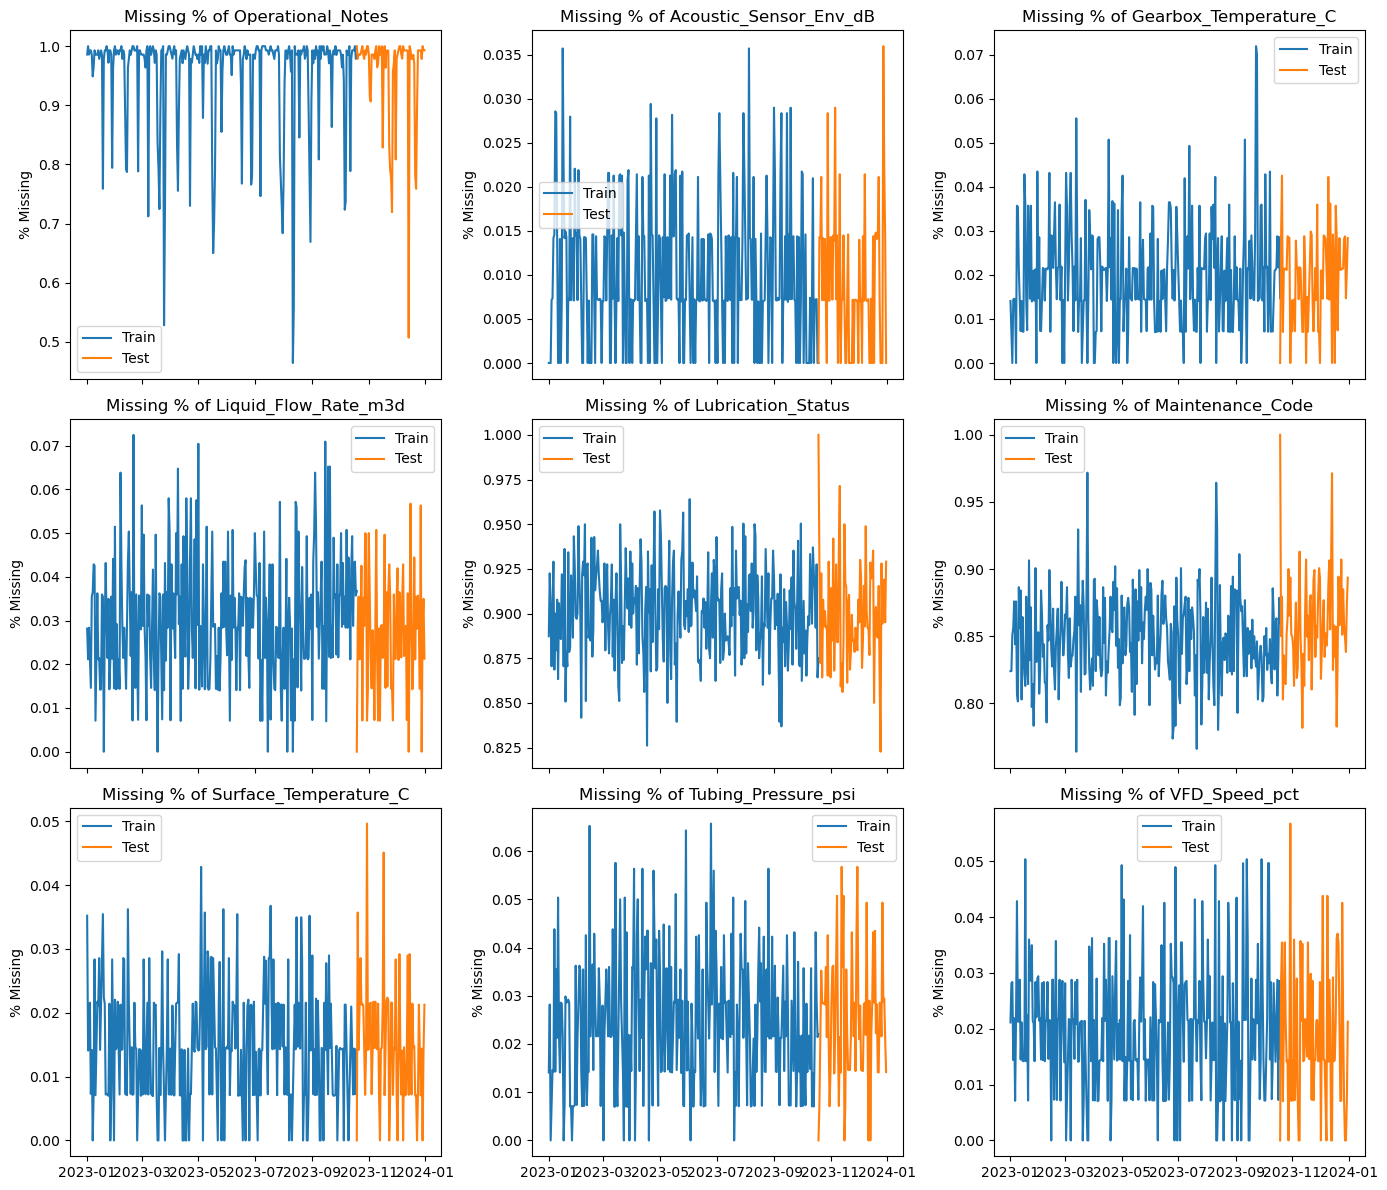

In [41]:
import math

# Align dates
train['Date'] = train['Timestamp'].dt.date
test['Date'] = test['Timestamp'].dt.date

# Define grid size based on number of columns
num_cols = len(mss_cols)
n_cols = 3  # Number of plots per row
n_rows = math.ceil(num_cols / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)
axes = axes.flatten()  # Make it easier to iterate

for i, col in enumerate(mss_cols):
    daily_missing_train = train.groupby('Date')[col].apply(lambda x: x.isna().mean())
    daily_missing_test = test.groupby('Date')[col].apply(lambda x: x.isna().mean())

    axes[i].plot(daily_missing_train, label='Train')
    axes[i].plot(daily_missing_test, label='Test')
    axes[i].set_title(f'Missing % of {col}')
    axes[i].set_ylabel('% Missing')
    axes[i].legend()

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The plot above shows the quantity of missing values over time are alike between training and test data set.

The distribution of missing values from training and test data sets seem to be similar to each other. The test error estimation from training data set could be valid.

Note: Categorical variables are missing huge


## Row-wise Missing Comparison

In [46]:
mss_r_tr = train.isna().mean(axis=1) * 100
mss_r_tst = test.isna().mean(axis=1) * 100

In [47]:
mss_r_tst_smmr = mss_r_tst.value_counts().reset_index()
mss_r_tr_smmr = mss_r_tr.value_counts().reset_index()

In [48]:
mss_r_tst_smmr.columns = ['test_missing_perc', 'test_counts']
mss_r_tr_smmr.columns = ['train_missing_perc', 'train_counts']

In [49]:
mss_r_tst_smmr['test_density'] = mss_r_tst_smmr['test_counts']/len(mss_r_tst) * 100
mss_r_tr_smmr['train_density'] = mss_r_tr_smmr['train_counts']/len(mss_r_tr) * 100

In [50]:
missing_summary_row = pd.concat([mss_r_tst_smmr, mss_r_tr_smmr], axis=1)

In [51]:
missing_summary_row['test_missing_perc'] = missing_summary_row['test_missing_perc']
missing_summary_row['test_missing_perc'] = missing_summary_row['train_missing_perc']

In [52]:
missing_summary_row[['test_missing_perc', 'test_density', 'train_missing_perc', 'train_density']].round(2)

test_missing_perc  test_density  train_missing_perc  train_density
0              11.54         67.76               11.54          66.88
1               7.69         21.84                7.69          22.28
2              15.38          8.46               15.38           8.79
3               3.85          1.92                3.85           1.99
4               0.00          0.02                0.00           0.06

Systematic missingness - there are not many missing cases in row-wise (missing columns are always missing regardless of train/test), and they can be categorized by 5 missing percentage for rows, and the distribution of missing cases is somewhat similar.  
**It looks like when a field is missing, then other fields are likely to be missing their values.** 

## Visualization: Column and Row Wise Missing Trends

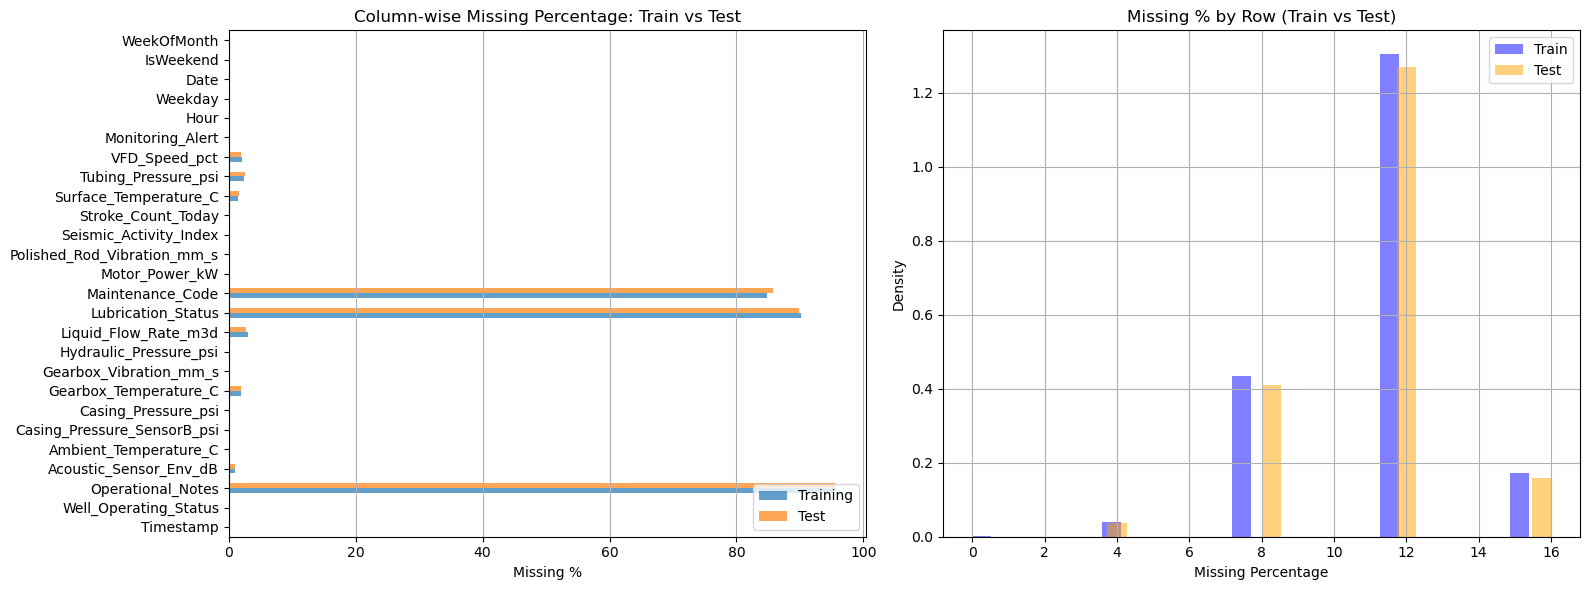

In [53]:
# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Column-wise Missing Percentage ---
missing_summary.plot(kind='barh', alpha=0.7, ax=axes[0])
axes[0].set_xlabel("Missing %")
axes[0].set_title("Column-wise Missing Percentage: Train vs Test")
axes[0].legend(loc='lower right')
axes[0].grid(axis='x')

# --- Plot 2: Row-wise Missing Percentage Histogram ---
axes[1].hist(mss_r_tr, bins=30, density=True, alpha=0.5, label='Train', color='blue')
axes[1].hist(mss_r_tst, bins=30, density=True, alpha=0.5, label='Test', color='orange')
axes[1].set_title('Missing % by Row (Train vs Test)')
axes[1].set_xlabel('Missing Percentage')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True)

# Final layout adjustment
plt.tight_layout()
plt.show()

Training and test data is likely to have identical distributions of missing values.

## Imputation 


### 1. Impute numerical variables with relatively low missing percentages
For the sake of modelling, forward filling and median filling are used to prevent data leakage.

In [54]:
def impute_time_series_features(df, columns):
    """
    Imputes missing values in a time series DataFrame:
    - First applies forward fill (`ffill`)
    - Then fills any remaining NaNs (typically at the beginning) with the median.

    Parameters:
        df (pd.DataFrame): Input DataFrame with time series columns.
        columns (list): List of column names to apply imputation to.

    Returns:
        pd.DataFrame: DataFrame with specified columns imputed.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].ffill()  # forward fill
            df[col] = df[col].fillna(df[col].median())  # remaining NaNs
    return df

In [55]:
col_impute = missing_summary.query('Training < 5 and Test < 5 and Training > 0 and Test > 0').index

In [56]:
col_impute

Index(['Acoustic_Sensor_Env_dB', 'Gearbox_Temperature_C',
       'Liquid_Flow_Rate_m3d', 'Surface_Temperature_C', 'Tubing_Pressure_psi',
       'VFD_Speed_pct'],
      dtype='object')

In [57]:
df = pd.concat([train, test], axis=0)
df_imp = impute_time_series_features(df, col_impute)

### 2. Impute categorical variables with heavily missing percentages

In [115]:
# Check if missing overlaps
missing_cols = ['Operational_Notes', 'Lubrication_Status', 'Maintenance_Code']
df[missing_cols].isna().sum(axis=1).value_counts()

3    37193
2    12624
1     1138
0       29
Name: count, dtype: int64

It is likey that the heavy missing categorical variables are due to the fact that the machine of interest is operating normal, and no manual note, lubrication, or maintanence were required. The trend of missing in row-wise and above table also support the argument. Hence, missing rows are filled with text value such as 'no_comment'.

In [59]:
df_imp['Operational_Notes'] = df_imp['Operational_Notes'].fillna('no_comment')

df_imp['Lubrication_Status'] = df_imp['Lubrication_Status'].cat.add_categories('Unknown')
df_imp['Lubrication_Status'] = df_imp['Lubrication_Status'].fillna('Unknown')

df_imp['Maintenance_Code'] = df_imp['Maintenance_Code'].cat.add_categories('NoCode')
df_imp['Maintenance_Code'] = df_imp['Maintenance_Code'].fillna('NoCode').astype(str)

In [60]:
df_imp.sample(5)

Timestamp Well_Operating_Status Operational_Notes  \
33561 2023-08-29 04:10:00             Operating        no_comment   
2271  2023-11-05 03:20:00             Operating        no_comment   
13561 2023-04-08 02:40:00             Operating        no_comment   
11629 2023-03-25 07:30:00             Operating        no_comment   
19947 2023-05-23 22:40:00             Operating        no_comment   

       Acoustic_Sensor_Env_dB  Ambient_Temperature_C  \
33561               47.544447              13.537737   
2271                41.075627              32.249806   
13561               53.268795              21.026740   
11629               43.140884              19.953477   
19947               40.625298               4.884069   

       Casing_Pressure_SensorB_psi  Casing_Pressure_psi  \
33561                    56.074415            53.654405   
2271                     53.773390            52.513522   
13561                    54.468311            52.845092   
11629                    53.048349            51.459814   
19947                    51.603373            50.065013   

       Gearbox_Temperature_C  Gearbox_Vibration_mm_s  Hydraulic_Pressure_psi  \
33561              76.205416                0.635615               27.331070   
2271               80.862229                0.612792               26.618682   
13561              73.838838                0.584596               29.802796   
11629              74.332628                0.491324               29.537270   
19947              72.510907                0.442949               30.679852   

       Liquid_Flow_Rate_m3d Lubrication_Status Maintenance_Code  \
33561             96.935435            Unknown           NoCode   
2271              96.766206            Unknown           NoCode   
13561             96.190934            Unknown            501.0   
11629             98.640935            Unknown           NoCode   
19947            100.151419            Unknown           NoCode   

       Motor_Power_kW  Polished_Rod_Vibration_mm_s  Seismic_Activity_Index  \
33561       55.132272                     1.046314                6.963311   
2271        59.542003                     0.781682               13.657584   
13561       53.867634                     0.292109               14.679372   
11629       51.067872                     0.802988                5.011848   
19947       57.952770                     0.744101                5.249170   

       Stroke_Count_Today  Surface_Temperature_C  Tubing_Pressure_psi  \
33561                 100              61.649110           178.175126   
2271                   80              62.047947           174.715088   
13561                  64              59.450293           194.586601   
11629                 180              59.674503           194.383378   
19947                 544              59.743568           190.198031   

       VFD_Speed_pct  Monitoring_Alert  Hour  Weekday        Date  IsWeekend  \
33561      75.048540               1.0     4        1  2023-08-29          0   
2271       73.860685               NaN     3        6  2023-11-05          1   
13561      61.142106               0.0     2        5  2023-04-08          1   
11629      72.207383               0.0     7        5  2023-03-25          1   
19947      76.947051               0.0    22        1  2023-05-23          0   

       WeekOfMonth  
33561            4  
2271             0  
13561            1  
11629            3  
19947            3

No missing found from imputed data set. 

# Bivariate Analysis

## Feature Engineering and Variable Selection

### Collect Feature Candidates
Now only focusing on training data set to find relevant engineered features for predicting label.

Split train (70%), validation (20%), test (10%) data for preventing overfitting, opmization bias, and maximizing model performance.

In [61]:
# Split index
n = len(train)
split_point = int(n * 0.7)  
split_point_ = int(n * 0.9)  

# Split data
train_imp = df_imp.iloc[train.index]
test_imp = df_imp.iloc[test.index]
sub_train = train_imp.iloc[:split_point]
val = train_imp.iloc[split_point:split_point_]
hold_out = train_imp.iloc[split_point_:]

From the ACF plots earlier, short term lags are found to be meaningful. Basic feature engineering with lag and rolling were tested below.
Spearman corelation was measured for numerical variables with the label as non-linear relationships are more likely. Mutual information was mesured for categorical variables with the label.

In [116]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

def generate_combined_features(df, y_col, num_cols, cat_cols, 
                               lags=[1, 2, 3, 6, 12, 36, 72, 144, 288], 
                               roll_windows=[6, 12, 36, 72, 144, 288], 
                               top_n=10,
                               corr_method='spearman'):
    """
    Generate lagged and rolling features for numeric columns,
    and lag/transition features for categorical columns.
    Select top_n features from each type based on relevance to target y_col.

    Parameters:
        df (pd.DataFrame): Input data.
        y_col (str): Target column.
        num_cols (list): Numerical feature names.
        cat_cols (list): Categorical feature names.
        lags (list): Time lags to generate.
        roll_windows (list): Rolling window sizes.
        top_n (int): Number of top features to keep per type.
        corr_method (str): Correlation method for numeric ('pearson' or 'spearman').

    Returns:
        final_df (pd.DataFrame): Selected features.
        scores_dict (dict): Feature scores {'numerical': Series, 'categorical': Series}.
    """
    df = df.copy()
    num_feature_frames = []
    cat_feature_frames = []
    corr_scores = {}

    # --- NUMERICAL FEATURES: Lag + Rolling ---
    for col in num_cols:
        for lag in lags:
            lagged = df[col].shift(lag)
            lag_name = f'{col}_lag_{lag}'
            num_feature_frames.append(lagged.rename(lag_name))
            corr_scores[lag_name] = lagged.corr(df[y_col], method=corr_method)

        for w in roll_windows:
            roll_mean = df[col].shift(1).rolling(window=w).mean()
            roll_std = df[col].shift(1).rolling(window=w).std()
            mean_name = f'{col}_rollmean_{w}'
            std_name = f'{col}_rollstd_{w}'
            num_feature_frames.append(roll_mean.rename(mean_name))
            num_feature_frames.append(roll_std.rename(std_name))
            corr_scores[mean_name] = roll_mean.corr(df[y_col], method=corr_method)
            corr_scores[std_name] = roll_std.corr(df[y_col], method=corr_method)

    # --- CATEGORICAL FEATURES: Lag + Transition ---
    for col in cat_cols:
        current = df[col].astype(str)
        for lag in lags:
            lagged = df[col].shift(lag).astype(str)
            lag_col_name = f'{col}_lag_{lag}'
            trans_col_name = f'{col}_transition_lag{lag}'

            cat_feature_frames.append(lagged.rename(lag_col_name))
            transition = (lagged + "_to_" + current).astype("category")
            cat_feature_frames.append(transition.rename(trans_col_name))

    # --- COMBINE ALL FEATURES ---
    all_features_df = pd.concat(num_feature_frames + cat_feature_frames, axis=1)

    # --- SELECT NUMERICAL FEATURES BY CORRELATION ---
    corr_series = pd.Series(corr_scores).dropna()
    top_num_features = corr_series.abs().sort_values(ascending=False).head(top_n).index.tolist()

    # --- SELECT CATEGORICAL FEATURES BY MUTUAL INFORMATION ---
    if cat_feature_frames:
        cat_df = pd.concat(cat_feature_frames, axis=1).astype("category")
        # Fast encoding for mutual info: use ordinal codes
        cat_df_encoded = cat_df.apply(lambda x: x.cat.codes)
        # Fill missing values to avoid errors
        cat_df_encoded = cat_df_encoded.fillna(-1)
        # Compute mutual information
        mi_scores = mutual_info_classif(cat_df_encoded, df[y_col])
        mi_series = pd.Series(mi_scores, index=cat_df.columns).sort_values(ascending=False)
        top_cat_features = mi_series.head(top_n).index.tolist()
    else:
        mi_series = pd.Series(dtype=float)
        top_cat_features = []

    # --- FINAL FEATURE SELECTION ---
    selected_cols = top_num_features + top_cat_features
    final_df = all_features_df[selected_cols]

    # Return selected features and scoring metadata
    return final_df, {'numerical': corr_series[top_num_features], 'categorical': mi_series[top_cat_features]}

In [124]:
selected_df, corr_mi_series = generate_combined_features(
    df=sub_train,
    y_col='Monitoring_Alert',
    num_cols=['Acoustic_Sensor_Env_dB', 'Ambient_Temperature_C',
       'Casing_Pressure_SensorB_psi', 'Casing_Pressure_psi',
       'Gearbox_Temperature_C', 'Gearbox_Vibration_mm_s',
       'Hydraulic_Pressure_psi', 'Liquid_Flow_Rate_m3d', 'Motor_Power_kW',
       'Polished_Rod_Vibration_mm_s', 'Seismic_Activity_Index',
       'Stroke_Count_Today', 'Surface_Temperature_C', 'Tubing_Pressure_psi',
       'VFD_Speed_pct'],
    cat_cols=['Well_Operating_Status', 'Operational_Notes',
       'Lubrication_Status', 'Maintenance_Code'],
    lags=[1, 2, 3, 6, 12, 36, 72, 144, 288, 432],
    roll_windows=[6, 12, 36, 72, 144, 288, 432],
    top_n=50
)

In [125]:
corr_mi_series['numerical']

Motor_Power_kW_rollmean_12                  0.320288
Motor_Power_kW_rollmean_6                   0.318028
Surface_Temperature_C_rollmean_6            0.313757
Surface_Temperature_C_rollmean_12           0.310808
Motor_Power_kW_rollmean_36                  0.305950
Surface_Temperature_C_lag_1                 0.295010
Surface_Temperature_C_lag_2                 0.292757
Surface_Temperature_C_lag_3                 0.291150
Surface_Temperature_C_rollmean_36           0.290402
Polished_Rod_Vibration_mm_s_rollmean_36     0.286890
Surface_Temperature_C_lag_6                 0.285309
Motor_Power_kW_rollmean_72                  0.282815
Polished_Rod_Vibration_mm_s_rollstd_144     0.277387
Motor_Power_kW_lag_1                        0.275148
Motor_Power_kW_lag_2                        0.273335
Surface_Temperature_C_lag_12                0.273296
Polished_Rod_Vibration_mm_s_rollmean_12     0.273088
Motor_Power_kW_lag_3                        0.271694
Motor_Power_kW_lag_6                        0.

In [126]:
corr_mi_series['categorical']

Operational_Notes_transition_lag2          0.108315
Operational_Notes_transition_lag3          0.105469
Operational_Notes_transition_lag1          0.104751
Operational_Notes_transition_lag6          0.103217
Operational_Notes_transition_lag12         0.099403
Operational_Notes_transition_lag36         0.092885
Operational_Notes_transition_lag72         0.084650
Operational_Notes_transition_lag144        0.068801
Operational_Notes_lag_1                    0.063434
Operational_Notes_lag_2                    0.062767
Operational_Notes_transition_lag432        0.060972
Operational_Notes_transition_lag288        0.060935
Operational_Notes_lag_6                    0.060799
Operational_Notes_lag_3                    0.060541
Operational_Notes_lag_12                   0.059189
Operational_Notes_lag_36                   0.046379
Operational_Notes_lag_72                   0.034787
Operational_Notes_lag_144                  0.019823
Well_Operating_Status_lag_432              0.009437
Well_Operati

### Subset of Features with High Correlation Values 

In [131]:
import re

def filter_and_deduplicate_features(score_series, threshold=0.2, is_mutual_info=False):
    """
    Filters and deduplicates features based on either correlation or mutual information scores.
    
    Parameters:
        score_series (pd.Series): Feature importance scores (feature name as index)
        threshold (float): Minimum score to keep
        is_mutual_info (bool): If True, input is mutual information (non-negative). 
                               If False, input is correlation (may be negative).
    
    Returns:
        pd.Series: Filtered and deduplicated scores
    """
    # Step 1: Filter by threshold
    if is_mutual_info:
        filtered = score_series[score_series >= threshold]
    else:
        filtered = score_series[score_series.abs() >= threshold]

    if filtered.empty:
        return pd.Series(dtype=score_series.dtype)  # empty result

    # Step 2: Extract base column name using regex
    base_names = filtered.index.to_series().apply(lambda x: re.split(r'_lag_|_rollmean_|_rollstd_|_transition_', x)[0])
    filtered_df = pd.DataFrame({
        'feature': filtered.index,
        'score': filtered.values,
        'base': base_names.values
    })

    # Step 3: Keep best feature per base column
    filtered_df['sort_score'] = filtered_df['score'].abs() if not is_mutual_info else filtered_df['score']
    top_per_base = (
        filtered_df.sort_values('sort_score', ascending=False)
        .groupby('base')
        .first()
        .sort_values('sort_score', ascending=False)
    )

    # Return as Series
    return top_per_base.set_index('feature')['score']

In [135]:
final_corrs = filter_and_deduplicate_features(corr_mi_series['numerical'], threshold=0.05)
print(final_corrs)

# To get final feature names:
cor_features = final_corrs.index.tolist()

feature
Motor_Power_kW_rollmean_12                 0.320288
Surface_Temperature_C_rollmean_6           0.313757
Polished_Rod_Vibration_mm_s_rollmean_36    0.286890
Tubing_Pressure_psi_rollmean_6            -0.235466
Gearbox_Temperature_C_rollmean_12          0.220945
Casing_Pressure_psi_rollstd_432           -0.220807
Gearbox_Vibration_mm_s_rollmean_36         0.194875
Name: score, dtype: float64


In [134]:
final_corrs = filter_and_deduplicate_features(corr_mi_series['categorical'], threshold=0.005, is_mutual_info=True)
print(final_corrs)

# To get final feature names:
mi_features = final_corrs.index.tolist()

feature
Operational_Notes_transition_lag2    0.108315
Well_Operating_Status_lag_432        0.009437
Lubrication_Status_lag_432           0.007114
Maintenance_Code_lag_36              0.006765
Name: score, dtype: float64


In [137]:
final_features = cor_features + mi_features

In [138]:
final_features

['Motor_Power_kW_rollmean_12',
 'Surface_Temperature_C_rollmean_6',
 'Polished_Rod_Vibration_mm_s_rollmean_36',
 'Tubing_Pressure_psi_rollmean_6',
 'Gearbox_Temperature_C_rollmean_12',
 'Casing_Pressure_psi_rollstd_432',
 'Gearbox_Vibration_mm_s_rollmean_36',
 'Operational_Notes_transition_lag2',
 'Well_Operating_Status_lag_432',
 'Lubrication_Status_lag_432',
 'Maintenance_Code_lag_36']

Create a function that will create the full selected and engineered features for the entire data set.

In [139]:
def generate_final_selected_features(df):
    """
    Generate engineered features based on final selection, including rolling mean, std, lag, and transition features
    for both numeric and categorical columns.

    Parameters:
        df (pd.DataFrame): Input time series DataFrame.

    Returns:
        pd.DataFrame: Original df with appended selected engineered features.
    """
    df = df.copy()

    # Feature specs: column -> list of operations
    # Supports: rollmean_X, rollstd_X, lag_X, transition_lagX
    feature_specs = {
        'Motor_Power_kW': ['rollmean_12'],
        'Surface_Temperature_C': ['rollmean_6'],
        'Polished_Rod_Vibration_mm_s': ['rollmean_36'],
        'Tubing_Pressure_psi': ['rollmean_6'],
        'Gearbox_Temperature_C': ['rollmean_12'],
        'Casing_Pressure_psi': ['rollstd_432'],
        'Gearbox_Vibration_mm_s': ['rollmean_36'],
        'Operational_Notes': ['transition_lag2'],
        'Well_Operating_Status': ['lag_432'],
        'Lubrication_Status': ['lag_432'],
        'Maintenance_Code': ['lag_36']
    }

    feature_frames = []

    for col, ops in feature_specs.items():
        if col not in df.columns:
            continue
        for op in ops:
            if op.startswith('rollmean_'):
                window = int(op.split('_')[-1])
                new_col = f"{col}_rollmean_{window}"
                series = df[col].shift(1).rolling(window=window).mean().rename(new_col)

            elif op.startswith('rollstd_'):
                window = int(op.split('_')[-1])
                new_col = f"{col}_rollstd_{window}"
                series = df[col].shift(1).rolling(window=window).std().rename(new_col)

            elif op.startswith('lag_'):
                lag = int(op.split('_')[-1])
                new_col = f"{col}_lag_{lag}"
                series = df[col].shift(lag).rename(new_col)

            elif op.startswith('transition_lag'):
                lag = int(op.split('transition_lag')[-1])
                lagged = df[col].shift(lag).astype(str)
                current = df[col].astype(str)
                new_col = f"{col}_transition_lag{lag}"
                series = (lagged + "_to_" + current).astype('category').rename(new_col)

            else:
                continue  # Skip unknown ops

            feature_frames.append(series)

    # Combine new features with original data
    feature_df = pd.concat(feature_frames, axis=1)
    final_df = pd.concat([df.reset_index(drop=True), feature_df.reset_index(drop=True)], axis=1)

    return final_df

In [142]:
split_point # Where we split train into sub_train and validation

28550

In [143]:
split_point_

36708

In [144]:
# 2. Generate features using combined data
train_feat = generate_final_selected_features(train_imp)
train_all = add_time_features(train_feat)
# 3. Split based on original val's index
sub_train_all = train_all.loc[:split_point]
val_all = train_all.loc[split_point:split_point_]

In [145]:
for col in final_features:
    print(sub_train_all[col].isna().sum()/len(sub_train_all))

0.00042030051486813074
0.00021015025743406537
0.0012609015446043922
0.00021015025743406537
0.00042030051486813074
0.015130818535252706
0.0012609015446043922
0.0
0.015130818535252706
0.015130818535252706
0.0012609015446043922


In [146]:
for col in final_features:
    print(val_all[col].isna().sum()/len(val_all))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Verified that features are well calculated, no missing values of concern.

###### Ordered Factors: Well_Operating_Status, Lubricate_Status

In [147]:
sub_train_all.columns

Index(['Timestamp', 'Well_Operating_Status', 'Operational_Notes',
       'Acoustic_Sensor_Env_dB', 'Ambient_Temperature_C',
       'Casing_Pressure_SensorB_psi', 'Casing_Pressure_psi',
       'Gearbox_Temperature_C', 'Gearbox_Vibration_mm_s',
       'Hydraulic_Pressure_psi', 'Liquid_Flow_Rate_m3d', 'Lubrication_Status',
       'Maintenance_Code', 'Motor_Power_kW', 'Polished_Rod_Vibration_mm_s',
       'Seismic_Activity_Index', 'Stroke_Count_Today', 'Surface_Temperature_C',
       'Tubing_Pressure_psi', 'VFD_Speed_pct', 'Monitoring_Alert', 'Hour',
       'Weekday', 'Date', 'IsWeekend', 'WeekOfMonth',
       'Motor_Power_kW_rollmean_12', 'Surface_Temperature_C_rollmean_6',
       'Polished_Rod_Vibration_mm_s_rollmean_36',
       'Tubing_Pressure_psi_rollmean_6', 'Gearbox_Temperature_C_rollmean_12',
       'Casing_Pressure_psi_rollstd_432', 'Gearbox_Vibration_mm_s_rollmean_36',
       'Operational_Notes_transition_lag2', 'Well_Operating_Status_lag_432',
       'Lubrication_Status_lag_432'

In [149]:
train_feat.tail()

Timestamp Well_Operating_Status Operational_Notes  \
40782 2023-10-19 22:10:00             Operating        no_comment   
40783 2023-10-19 22:20:00             Operating        no_comment   
40784 2023-10-19 22:30:00             Operating        no_comment   
40785 2023-10-19 22:40:00             Operating        no_comment   
40786 2023-10-19 22:50:00             Operating        no_comment   

       Acoustic_Sensor_Env_dB  Ambient_Temperature_C  \
40782               47.006170              27.796794   
40783               43.819635              29.067319   
40784               39.870584              26.203226   
40785               42.382936              29.882131   
40786               41.490541              21.044725   

       Casing_Pressure_SensorB_psi  Casing_Pressure_psi  \
40782                    51.779890            52.239625   
40783                    54.324112            51.889230   
40784                    54.024466            53.048127   
40785                    52.041916            52.188194   
40786                    53.847841            52.091557   

       Gearbox_Temperature_C  Gearbox_Vibration_mm_s  Hydraulic_Pressure_psi  \
40782              78.502460                0.768184               29.735330   
40783              81.480187                0.556077               28.592517   
40784              79.351414                0.600903               28.322948   
40785              81.092399                0.678572               26.617094   
40786              78.772902                0.603118               29.100776   

       Liquid_Flow_Rate_m3d Lubrication_Status Maintenance_Code  \
40782             93.570676            Unknown           NoCode   
40783             95.504386            Unknown           NoCode   
40784             99.713693            Unknown           NoCode   
40785             98.897580            Unknown           NoCode   
40786             98.644692            Unknown            501.0   

       Motor_Power_kW  Polished_Rod_Vibration_mm_s  Seismic_Activity_Index  \
40782       61.133114                     0.664310                7.125267   
40783       60.979545                     0.901394                7.119402   
40784       60.503607                     1.183279                7.113542   
40785       58.616558                     0.925305                7.107688   
40786       54.031844                     0.912719                7.101840   

       Stroke_Count_Today  Surface_Temperature_C  Tubing_Pressure_psi  \
40782                 532              62.972613           176.756007   
40783                 536              64.057764           173.614143   
40784                 540              63.447410           175.293320   
40785                 544              64.604148           183.049578   
40786                 548              63.893351           173.772663   

       VFD_Speed_pct  Monitoring_Alert  Hour  Weekday        Date  IsWeekend  \
40782      69.007892               0.0    22        3  2023-10-19          0   
40783      82.765583               0.0    22        3  2023-10-19          0   
40784      80.269623               0.0    22        3  2023-10-19          0   
40785      75.368733               0.0    22        3  2023-10-19          0   
40786      68.252870               0.0    22        3  2023-10-19          0   

       WeekOfMonth  Motor_Power_kW_rollmean_12  \
40782            2                   58.397577   
40783            2                   58.467255   
40784            2                   58.572264   
40785            2                   58.999713   
40786            2                   58.883119   

       Surface_Temperature_C_rollmean_6  \
40782                         63.795996   
40783                         63.624832   
40784                         64.037415   
40785                         63.825014   
40786                         63.448906   

       Polished_Rod_Vibration_mm_s_rollmean_36  \
40782                     

# Variable Selection 

Steps
1. Start with all of the engineered features included
2. Drop one referencing feature importance plot and SHAP figure, aiming for reducing false negative (and false positive)
3. Stop dropping when the model performance starts decreasing to prevent over fitting


## 0. Full Model

In [212]:
time_vals = ['Hour', 'Weekday', 'IsWeekend', 'WeekOfMonth']
scale = len(sub_train_all[sub_train_all['Monitoring_Alert'] == 0]) / len(sub_train_all[sub_train_all['Monitoring_Alert'] == 1])

In [213]:
from xgboost import XGBClassifier

# Define your categorical features (ensure proper dtype)
categorical_cols = [
    'Operational_Notes_transition_lag2',
    'Well_Operating_Status_lag_432',
    'Lubrication_Status_lag_432',
    'Maintenance_Code_lag_36'
]

# Make sure they are category dtype
for col in categorical_cols:
    sub_train_all.loc[:, col] = sub_train_all[col].astype('category')

# Define model
model = XGBClassifier(
    n_estimators=500, 
    max_depth=9, 
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale,
    reg_alpha=0.5, 
    reg_lambda=1,
    enable_categorical=True,
    tree_method='hist',               # needed for categorical support
    eval_metric='logloss'            # optional, matches your earlier `params`
)

In [214]:
# Fit model
model.fit(
    sub_train_all[final_features + time_vals],
    sub_train_all['Monitoring_Alert'],
    verbose=50
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

Validation error obtained from val_all (feature engineered covariate + timestamp deriven temporal info)

In [215]:
# Convert dtype and align categories with training set
for col in categorical_cols:
    val_all.loc[:,col] = pd.Categorical(val_all[col], categories=sub_train_all[col].cat.categories)


In [216]:
y_val_prob = model.predict_proba(val_all[final_features + time_vals])[:, 1]
y_val_pred = (y_val_prob >= 0.3).astype(int)

print("Classification Report:\n", classification_report(val_all['Monitoring_Alert'], y_val_pred))
print("AUC:", roc_auc_score(val_all['Monitoring_Alert'], y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(val_all['Monitoring_Alert'], y_val_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      6974
         1.0       0.36      0.84      0.50      1185

    accuracy                           0.76      8159
   macro avg       0.66      0.79      0.67      8159
weighted avg       0.88      0.76      0.79      8159

AUC: 0.8407624945699458
Confusion Matrix:
 [[5213 1761]
 [ 191  994]]


Note:   
Precision: TP/(TP + FP)   
Of all predicted, how many are true? 737/(4119 + 737) = 0.15

Recall = sensitivity = TP/(TP + FN)  
Of all actual alerts, how many were caught? 0.95  

False positive: alert is on when normal (not efficient business for Ambyint)  
False negative: alerting situation but SaaS is idle (risky situation - must be avoided)  

Minimizing FN is important for Ambyint's prolong business. High false negative value would result in losing trust on clients.
Recall is important as to catch alerting situation is the main focus of the business.

There are many false positives (not alertable but alerting).
Not that many false negative. 

F1 Score: f(precision, recall), balances the trade-off   

Accuracy is misleading as classes are imbalanced. 


In [217]:
val_all['Monitoring_Alert'].value_counts()

Monitoring_Alert
0.0    6974
1.0    1185
Name: count, dtype: int64

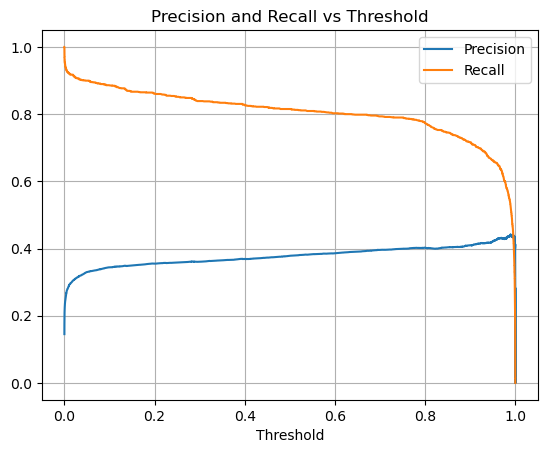

In [218]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_all[label], y_val_prob)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.title('Precision and Recall vs Threshold')
plt.show()

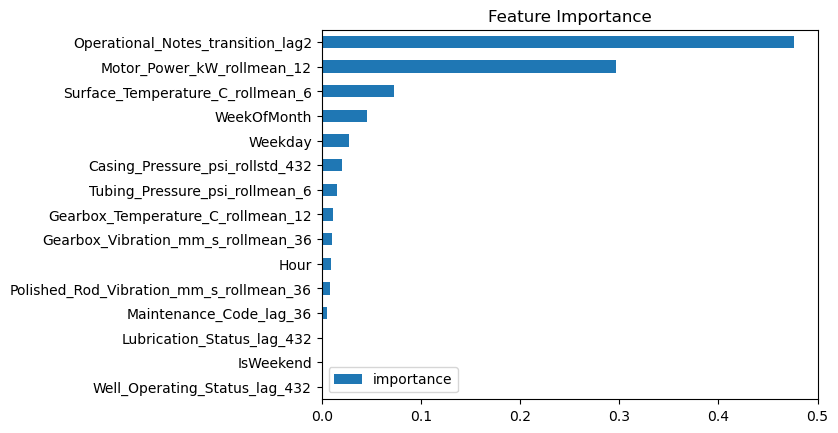

In [219]:
fi = pd.DataFrame(data = model.feature_importances_,
                 index = model.feature_names_in_,
                 columns = ['importance'])
fi.sort_values('importance').plot(kind= 'barh', title ='Feature Importance')
plt.show()

In [220]:
print(fi.sort_values('importance', ascending= False))

                                         importance
Operational_Notes_transition_lag2          0.476398
Motor_Power_kW_rollmean_12                 0.296885
Surface_Temperature_C_rollmean_6           0.072887
WeekOfMonth                                0.045283
Weekday                                    0.027808
Casing_Pressure_psi_rollstd_432            0.020046
Tubing_Pressure_psi_rollmean_6             0.015616
Gearbox_Temperature_C_rollmean_12          0.011449
Gearbox_Vibration_mm_s_rollmean_36         0.010627
Hour                                       0.009297
Polished_Rod_Vibration_mm_s_rollmean_36    0.008465
Maintenance_Code_lag_36                    0.004850
Lubrication_Status_lag_432                 0.000389
Well_Operating_Status_lag_432              0.000000
IsWeekend                                  0.000000


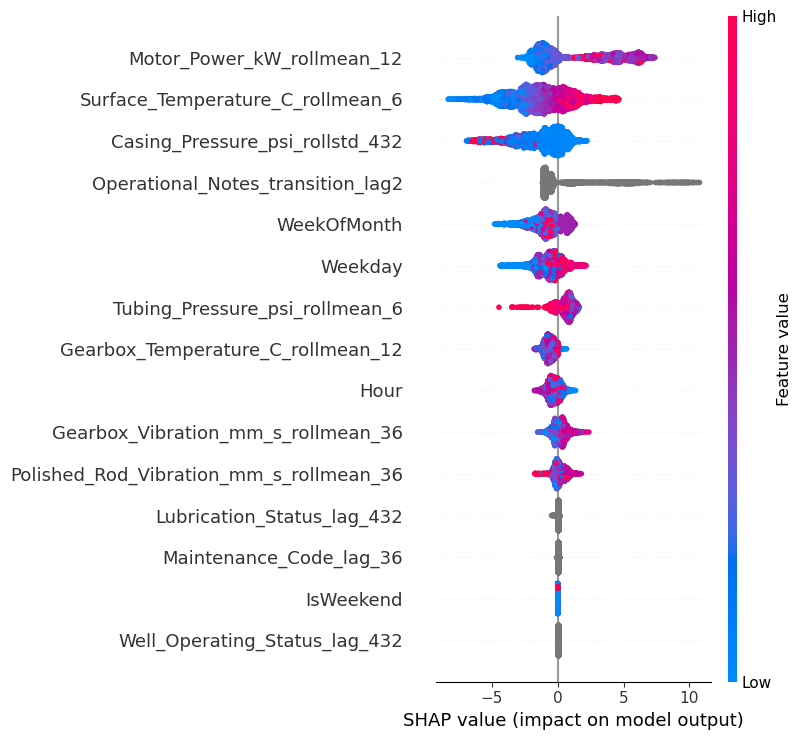

In [221]:
import shap
# Step 1: Create SHAP explainer
explainer = shap.Explainer(model)  # Works with XGBoost 1.5+
# If this fails, use: shap.TreeExplainer(model)

# Step 2: Compute SHAP values for your validation set
shap_values = explainer(val_all[final_features + time_vals])

# Step 3: Summary plot (global feature importance + direction)
shap.summary_plot(shap_values, val_all[final_features + time_vals])

In [222]:
fi_df = pd.DataFrame(fi).reset_index()

In [223]:
fi_df.sort_values(by = 'importance', ascending = True)

index  importance
8             Well_Operating_Status_lag_432    0.000000
13                                IsWeekend    0.000000
9                Lubrication_Status_lag_432    0.000389
10                  Maintenance_Code_lag_36    0.004850
2   Polished_Rod_Vibration_mm_s_rollmean_36    0.008465
11                                     Hour    0.009297
6        Gearbox_Vibration_mm_s_rollmean_36    0.010627
4         Gearbox_Temperature_C_rollmean_12    0.011449
3            Tubing_Pressure_psi_rollmean_6    0.015616
5           Casing_Pressure_psi_rollstd_432    0.020046
12                                  Weekday    0.027808
14                              WeekOfMonth    0.045283
1          Surface_Temperature_C_rollmean_6    0.072887
0                Motor_Power_kW_rollmean_12    0.296885
7         Operational_Notes_transition_lag2    0.476398

## 1. Remove Well_Operating_Status_lag_432 

In [224]:
fi_list = fi_df['index'].tolist().copy()

In [226]:
to_drop = ['Well_Operating_Status_lag_432']
wo_1 = [x for x in fi_list if x not in to_drop]

In [228]:
model.fit(sub_train_all[wo_1], sub_train_all['Monitoring_Alert'],
         verbose = 50)

y_val_pred = model.predict(val_all[wo_1])
y_val_prob = model.predict_proba(val_all[wo_1])[:, 1]

threshold = 0.3  # try different values
y_val_pred = (y_val_prob >= threshold).astype(int)

print("Classifacation Report: \n", classification_report(val_all[label], y_val_pred))
print("AUC:", roc_auc_score(val_all[label], y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(val_all[label], y_val_pred))

Classifacation Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      6974
         1.0       0.36      0.84      0.50      1185

    accuracy                           0.76      8159
   macro avg       0.66      0.79      0.67      8159
weighted avg       0.88      0.76      0.79      8159

AUC: 0.8407624945699458
Confusion Matrix:
 [[5213 1761]
 [ 191  994]]


Droping the first varible was not very impactful.

## 2. Remove IsWeekend based on SHAP

In [229]:
to_drop = ['IsWeekend']
wo_1 = [x for x in fi_list if x not in to_drop]

In [230]:
wo_2

['Motor_Power_kW_rollmean_12',
 'Surface_Temperature_C_rollmean_6',
 'Polished_Rod_Vibration_mm_s_rollmean_36',
 'Tubing_Pressure_psi_rollmean_6',
 'Gearbox_Temperature_C_rollmean_12',
 'Casing_Pressure_psi_rollstd_432',
 'Gearbox_Vibration_mm_s_rollmean_36',
 'Operational_Notes_transition_lag2',
 'Lubrication_Status_lag_432',
 'Maintenance_Code_lag_36',
 'Hour',
 'Weekday',
 'WeekOfMonth']

In [231]:
model.fit(sub_train_all[wo_2], sub_train_all['Monitoring_Alert'],
         verbose = 50)

y_val_pred = model.predict(val_all[wo_2])
y_val_prob = model.predict_proba(val_all[wo_2])[:, 1]

threshold = 0.3  # try different values
y_val_pred = (y_val_prob >= threshold).astype(int)

print("Classifacation Report: \n", classification_report(val_all[label], y_val_pred))
print("AUC:", roc_auc_score(val_all[label], y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(val_all[label], y_val_pred))

Classifacation Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      6974
         1.0       0.36      0.84      0.50      1185

    accuracy                           0.76      8159
   macro avg       0.66      0.79      0.67      8159
weighted avg       0.88      0.76      0.79      8159

AUC: 0.8407624945699458
Confusion Matrix:
 [[5213 1761]
 [ 191  994]]


Same as before - was not very impactful

## 3. Remove Lubrication_Status_lag_432 based on SHAP

In [232]:
to_drop = ['Lubrication_Status_lag_432']
wo_3 = [x for x in wo_2 if x not in to_drop]

In [233]:
model.fit(sub_train_all[wo_3], sub_train_all['Monitoring_Alert'],
         verbose = 50)

y_val_pred = model.predict(val_all[wo_3])
y_val_prob = model.predict_proba(val_all[wo_3])[:, 1]

threshold = 0.3  # try different values
y_val_pred = (y_val_prob >= threshold).astype(int)

print("Classifacation Report: \n", classification_report(val_all[label], y_val_pred))
print("AUC:", roc_auc_score(val_all[label], y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(val_all[label], y_val_pred))

Classifacation Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      6974
         1.0       0.36      0.84      0.51      1185

    accuracy                           0.76      8159
   macro avg       0.66      0.79      0.67      8159
weighted avg       0.88      0.76      0.79      8159

AUC: 0.8404891465467275
Confusion Matrix:
 [[5220 1754]
 [ 190  995]]


## 4. Remove Maintenance_Code_lag_36

In [236]:
to_drop = ['Maintenance_Code_lag_36']
temp = [x for x in wo_3 if x not in to_drop]

model.fit(sub_train_all[temp], sub_train_all['Monitoring_Alert'],
         verbose = 50)
y_val_pred = model.predict(val_all[temp])
y_val_prob = model.predict_proba(val_all[temp])[:, 1]

threshold = 0.3  # try different values
y_val_pred = (y_val_prob >= threshold).astype(int)

print("Classifacation Report: \n", classification_report(val_all[label], y_val_pred))
print("AUC:", roc_auc_score(val_all[label], y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(val_all[label], y_val_pred))

Classifacation Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      6974
         1.0       0.36      0.82      0.50      1185

    accuracy                           0.76      8159
   macro avg       0.66      0.79      0.67      8159
weighted avg       0.87      0.76      0.79      8159

AUC: 0.8362794780855716
Confusion Matrix:
 [[5244 1730]
 [ 208  977]]


From here, false negative is increasing, so we stop proceeding to the step 4, and step 3 is the final model selection. For the sake of illustration, smaller model with feature importance feature is attemped below.

## 4. Remove Features < 0.015 Importance

In [208]:
feature_003 = fi_df[fi_df['importance'] > 0.015]['index']

model.fit(sub_train_all[list(feature_003)], sub_train_all['Monitoring_Alert'],
         verbose = 50)

y_val_pred = model.predict(val_all[feature_003])
y_val_prob = model.predict_proba(val_all[feature_003])[:, 1]

In [209]:
threshold = 0.3  # try different values
y_val_pred = (y_val_prob >= threshold).astype(int)

print("Classifacation Report: \n", classification_report(val_all[label], y_val_pred))
print("AUC:", roc_auc_score(val_all[label], y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(val_all[label], y_val_pred))

Classifacation Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.75      0.84      6974
         1.0       0.33      0.75      0.46      1185

    accuracy                           0.75      8159
   macro avg       0.64      0.75      0.65      8159
weighted avg       0.86      0.75      0.78      8159

AUC: 0.8019629872982108
Confusion Matrix:
 [[5218 1756]
 [ 301  884]]


It is shown that FN is even more increased and it is recommended to stick to the 3rd model.

In [211]:
feature_003

0            Motor_Power_kW_rollmean_12
1      Surface_Temperature_C_rollmean_6
3        Tubing_Pressure_psi_rollmean_6
5       Casing_Pressure_psi_rollstd_432
7     Operational_Notes_transition_lag2
12                              Weekday
14                          WeekOfMonth
Name: index, dtype: object

In [237]:
print("Selected variables: \n", wo_3)

Selected variables: 
 ['Motor_Power_kW_rollmean_12', 'Surface_Temperature_C_rollmean_6', 'Polished_Rod_Vibration_mm_s_rollmean_36', 'Tubing_Pressure_psi_rollmean_6', 'Gearbox_Temperature_C_rollmean_12', 'Casing_Pressure_psi_rollstd_432', 'Gearbox_Vibration_mm_s_rollmean_36', 'Operational_Notes_transition_lag2', 'Maintenance_Code_lag_36', 'Hour', 'Weekday', 'WeekOfMonth']


#### Todo: Use models like LightGBM and average feature importance over multiple TimeSeriesSplit folds.

# 3. Hyper Parameter Tuning

## Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# 1. Split 90% of training data for tuning
train_cv_data = train_all.loc[:split_point_].copy()

# 2. Ensure all categorical features are of type 'category'
categorical_cols = [
    'Operational_Notes_transition_lag2',
    'Well_Operating_Status_lag_432',
    'Lubrication_Status_lag_432',
    'Maintenance_Code_lag_36'
]
for col in categorical_cols:
    if col in train_cv_data.columns:
        train_cv_data[col] = pd.Categorical(train_cv_data[col])

# 3. Define your features and label
X = train_cv_data[wo_3]  # wo_3 is your feature list
y = train_cv_data['Monitoring_Alert']

# 4. TimeSeriesSplit setup
tss = TimeSeriesSplit(n_splits=5, test_size=3700)

# 5. Define model with categorical support
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    enable_categorical=True,
    tree_method='hist'
)

# 6. Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 7. Use ROC AUC as scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

# 8. Grid search with time series cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=tss,
    verbose=1,
    n_jobs=-1
)

# 9. Fit grid search
grid_search.fit(X, y)

# 10. Output best model and params
print("Best ROC AUC Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 11. Extract the best model
best_model = grid_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:
!pip install joblib

In [ ]:
import joblib
joblib.dump(best_model, 'xgb_final_model.pkl')

In [109]:
# # Load the saved model
# loaded_model = joblib.load('xgb_final_model.pkl')

# # Use it
# y_pred = loaded_model.predict(X_new)

In [110]:
hold_out_cv_data = train_all.iloc[split_point_:]

In [111]:
hold_out_cv_data.shape

(4079, 37)

In [112]:
X_holdout = hold_out_cv_data[wo_1]
y_holdout = hold_out_cv_data['Monitoring_Alert']

# 2. Predict probabilities and class labels
y_prob = best_model.predict_proba(X_holdout)[:, 1]
y_pred = best_model.predict(X_holdout)

In [113]:
# 3. Evaluate
threshold = 0.3
y_pred_custom = (y_prob >= threshold).astype(int)

print("\n🔍 AUC (custom threshold):", roc_auc_score(y_holdout, y_prob))
print("\n📋 Report (threshold=0.3):\n", classification_report(y_holdout, y_pred_custom))
print("\n🧮 Confusion Matrix:\n", confusion_matrix(y_holdout, y_pred_custom))


🔍 AUC (custom threshold): 0.8245778364116094

📋 Report (threshold=0.3):
               precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      3700
         1.0       0.26      0.66      0.38       379

    accuracy                           0.80      4079
   macro avg       0.61      0.74      0.63      4079
weighted avg       0.89      0.80      0.83      4079


🧮 Confusion Matrix:
 [[2997  703]
 [ 128  251]]


Example: